In [1]:
dataset = 'data/raw/updated_only_smiles.csv'
df = pd.read_csv(dataset)
print(df.head()) 
df.shape

  DrugBank ID          Name  \
0     DB00006   Bivalirudin   
1     DB00007    Leuprolide   
2     DB00014     Goserelin   
3     DB00027  Gramicidin D   
4     DB00035  Desmopressin   

                                         Description   State  \
0  Bivalirudin is a synthetic 20 residue peptide ...   solid   
1  Leuprolide is a synthetic 9-residue peptide an...   solid   
2  Goserelin is a synthetic hormone. In men, it s...   solid   
3  Gramcidin D is a heterogeneous mixture of thre...  liquid   
4  Desmopressin (dDAVP), a synthetic analogue of ...   solid   

                      Groups  \
0  approved; investigational   
1  approved; investigational   
2                   approved   
3                   approved   
4                   approved   

                                          Categories  \
0  Amino Acids, Peptides, and Proteins; Anticoagu...   
1  Adrenal Cortex Hormones; Agents Causing Muscle...   
2  Adrenal Cortex Hormones; Amino Acids, Peptides...   
3  Amino Ac

(11925, 11)

In [3]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
import pandas as pd
import numpy as np 
import os
import os.path as osp

import torch
from torch_geometric.data import Dataset, Data, download_url 
from rdkit.Chem import rdmolops


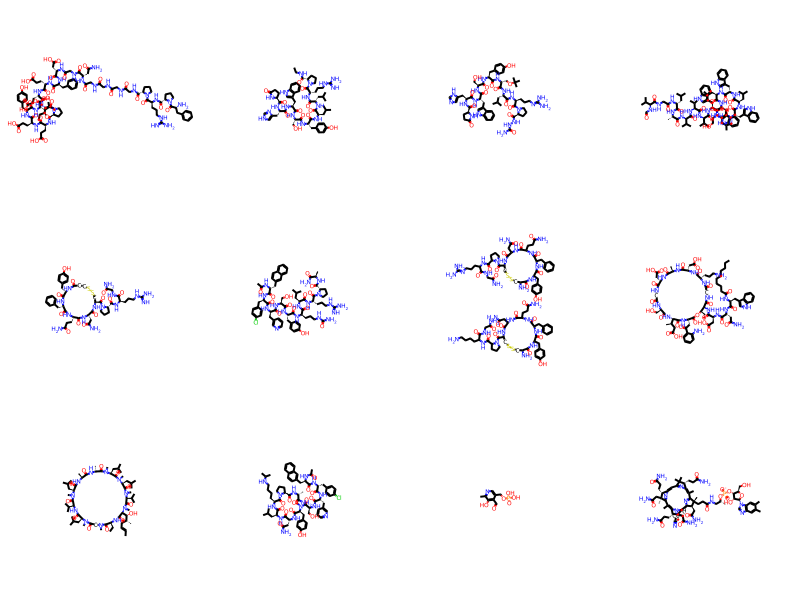

In [4]:
df['SMILES'] = df['SMILES'].astype(str)
sample_smiles = df["SMILES"][0:12].values
sample_mols = [Chem.MolFromSmiles(smiles)for \
              smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,
                           molsPerRow = 4,
                           subImgSize = (200,200))
grid

In [24]:
from scipy.sparse import coo_matrix
import deepchem as dc
from rdkit import Chem 
df['SMILES'] = df['SMILES'].astype(str).replace('NoneType', '')
class DopingDataset(Dataset):
    def __init__(self, root, filename, atom_map, test=False, transform=None, pre_transform=None, pre_filter=None):
        self.test = test
        self.filename = filename
        self.atom_map = atom_map
        super(DopingDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return self.filename
    
    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            mol = Chem.MolFromSmiles(row["SMILES"])
            f = featurizer._featurize(mol)
            data = f.to_pyg_graph()
            data.y = self._get_label(row["Doping"])
            data.smiles = row["SMILES"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))


    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():

            atom_symbol = atom.GetSymbol()
            node_feats = [int(atom_symbol == atom_type) for atom_type in self.atom_map]
            all_node_feats.append(node_feats)

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)
    
    # def _get_edge_features(self, mol):
    #     """ 
    #     This will return a matrix / 2d array of the shape
    #     [Number of edges, Edge Feature size]
    #     """
    #     all_edge_feats = []

    #     for atom in mol.GetAtoms():
    #         for bond in atom.GetBonds():
    #             edge_feats = []
    #             # Feature 1: Map valence integers as specified
    #             valence = bond.GetBeginAtom().GetTotalValence()
    #             mapped_valence = min(valence, 4)  # Cap valence at 5

    #             # Create edge feature vector
    #             edge_feats = [1.0 if i == (mapped_valence - 1) else 0.0 for i in range(5)]

    #             all_edge_feats.append(edge_feats)

    #     all_edge_feats = np.asarray(all_edge_feats)
    #     return torch.tensor(all_edge_feats, dtype=torch.float)
        
    def _get_edge_features(self, mol):
        all_edge_feats = []
        bond_type_map = {
            Chem.rdchem.BondType.SINGLE: 0,
            Chem.rdchem.BondType.DOUBLE: 1,
            Chem.rdchem.BondType.TRIPLE: 2,
            Chem.rdchem.BondType.AROMATIC: 3
        }
        for bond in mol.GetBonds():
            edge_feats = []
            bond_type = bond.GetBondType()
            edge_feats.append(bond_type_map.get(bond_type, -1))  # Convert bond type to integer label
            all_edge_feats += [edge_feats, edge_feats]
        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)


    # def _get_adjacency_info(self, mol):
    #     """
    #     We could also use rdmolops.GetAdjacencyMatrix(mol)
    #     but we want to be sure that the order of the indices
    #     matches the order of the edge features
    #     """
    #     edge_indices = []
    #     for bond in mol.GetBonds():
    #         i = bond.GetBeginAtomIdx()
    #         j = bond.GetEndAtomIdx()
    #         edge_indices += [[i, j], [j, i]]

    #     edge_indices = torch.tensor(edge_indices)
    #     edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    #     return edge_indices
    
    # def _get_adjacency_info(self, mol):
    #     """
    #     Get adjacency information of the molecule.
    #     """
    #     # Get the adjacency matrix of the molecule
    #     adjacency_matrix = rdmolops.GetAdjacencyMatrix(mol)

    #     # Convert the adjacency matrix to a list of indices for non-zero entries
    #     edge_indices = torch.nonzero(torch.tensor(adjacency_matrix), as_tuple=False)
        
    #     # Convert the indices to a 2xN tensor
    #     edge_indices = edge_indices.t().to(torch.long)

    #     return edge_indices


    def _get_adjacency_info(self, mol):
        # Obtain the adjacency matrix
        adj_matrix = Chem.GetAdjacencyMatrix(mol)
        
        # Convert the adjacency matrix to COO format
        coo = coo_matrix(adj_matrix)
        
        # Extract row, col indices
        edge_indices = np.vstack((coo.row, coo.col))
        
        # Convert to torch tensor
        edge_indices = torch.tensor(edge_indices, dtype=torch.long)
        
        return edge_indices


    def find_isolated_nodes(self, edge_index, num_nodes):
        """
        Find isolated nodes in the graph.

        Parameters:
            edge_index (Tensor): Edge indices of the graph.
            num_nodes (int): Total number of nodes in the graph.

        Returns:
            isolated_nodes (list): List of isolated node indices.
        """
        # Convert edge index to a numpy array
        edge_index_np = edge_index.numpy()

        # Create an array to keep track of which nodes have edges
        has_edge = np.zeros(num_nodes, dtype=bool)

        # Mark nodes that have edges
        for edge in edge_index_np.T:
            has_edge[edge] = True

        # Find nodes without edges (isolated nodes)
        isolated_nodes = np.where(~has_edge)[0]

        return isolated_nodes

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [30]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset
import numpy as np 
import os
from tqdm import tqdm
import deepchem as dc
from rdkit import Chem 


class DopingDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        super(DopingDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["SMILES"])
            if mol is None:
                print(f"Invalid SMILES string at index {index}: {row['SMILES']}")
                continue
            try:
                f = featurizer._featurize(mol)
                if len(f.edge_index) == 0 or f.edge_features is None or f.edge_features.size == 0:
                    print(f"No bonds found in molecule at index {index}: {row['SMILES']}")
                    continue
                data = f.to_pyg_graph()
                data.y = self._get_label(row["Doping"])
                data.smiles = row["SMILES"]
                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))        
        return data

# Instantiate the dataset
dataset = DopingDataset(root="data", filename="updated_only_smiles.csv")


Processing...
  5%|▌         | 654/11925 [00:13<02:48, 66.99it/s]

Error processing molecule at index 642: tuple index out of range


  9%|▊         | 1042/11925 [00:20<03:00, 60.35it/s]

Error processing molecule at index 1032: tuple index out of range


 10%|▉         | 1177/11925 [00:25<07:01, 25.53it/s]

Error processing molecule at index 1172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1182: More than one atom should be present in the molecule for this featurizer to work.


 10%|█         | 1200/11925 [00:25<04:03, 44.12it/s]

Error processing molecule at index 1191: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1192: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1194: tuple index out of range
Error processing molecule at index 1195: More than one atom should be present in the molecule for this featurizer to work.


 12%|█▏        | 1377/11925 [00:28<03:04, 57.31it/s]

Error processing molecule at index 1368: tuple index out of range


 12%|█▏        | 1391/11925 [00:28<03:29, 50.22it/s]

Error processing molecule at index 1384: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1385: More than one atom should be present in the molecule for this featurizer to work.


 14%|█▍        | 1697/11925 [00:34<03:06, 54.88it/s]

Invalid SMILES string at index 1691: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O


 15%|█▍        | 1759/11925 [00:35<02:53, 58.68it/s][01:29:55] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[01:29:55] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
 15%|█▍        | 1768/11925 [00:35<02:39, 63.81it/s]

Invalid SMILES string at index 1760: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]


 16%|█▌        | 1924/11925 [00:38<02:42, 61.41it/s]

Error processing molecule at index 1916: tuple index out of range


 20%|██        | 2392/11925 [00:46<02:30, 63.14it/s]

Invalid SMILES string at index 2382: COC1=CC=C2N(C=NC2=C1)[C@H]1O[C@H](CO)[C@@H](O[P@]([OH-])(=O)O[C@H](C)CNC(=O)CC[C@]2(C)[C@@H](CC(N)=O)C3=[N+]4C2=C(C)C2=[N+]5C(=CC6=[N+]7C(=C(C)C8=[N+]([C@]3(C)[C@@](C)(CC(N)=O)[C@@H]8CCC(N)=O)[Co@@]457)[C@@](C)(CC(N)=O)[C@@H]6CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O)[C@H]1O


 31%|███       | 3721/11925 [01:09<02:06, 65.02it/s]

Invalid SMILES string at index 3717: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3


 31%|███▏      | 3749/11925 [01:10<02:34, 52.88it/s]

Error processing molecule at index 3736: tuple index out of range


 34%|███▎      | 4014/11925 [01:14<01:50, 71.54it/s]

Error processing molecule at index 4008: tuple index out of range


 34%|███▍      | 4044/11925 [01:15<02:43, 48.16it/s]

Invalid SMILES string at index 4034: F[Al](F)(F)[F-]


 41%|████      | 4856/11925 [01:38<02:51, 41.27it/s]

Error processing molecule at index 4847: tuple index out of range


 43%|████▎     | 5101/11925 [01:45<02:33, 44.33it/s]

Error processing molecule at index 5092: tuple index out of range
Error processing molecule at index 5098: tuple index out of range


 43%|████▎     | 5141/11925 [01:45<02:16, 49.79it/s]

Error processing molecule at index 5130: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 5135: tuple index out of range


 55%|█████▌    | 6596/11925 [02:08<01:25, 62.34it/s]

Invalid SMILES string at index 6587: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


 60%|██████    | 7180/11925 [02:18<01:30, 52.41it/s]

Error processing molecule at index 7166: tuple index out of range


 62%|██████▏   | 7335/11925 [02:21<02:05, 36.61it/s]

Error processing molecule at index 7323: tuple index out of range
Error processing molecule at index 7338: tuple index out of range
Error processing molecule at index 7339: More than one atom should be present in the molecule for this featurizer to work.


 62%|██████▏   | 7363/11925 [02:21<01:13, 62.41it/s]

Error processing molecule at index 7352: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7359: tuple index out of range
Error processing molecule at index 7361: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7476/11925 [02:23<01:03, 70.48it/s]

Error processing molecule at index 7468: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7484/11925 [02:23<01:08, 64.63it/s]

Error processing molecule at index 7482: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7515/11925 [02:24<01:12, 60.76it/s]

Error processing molecule at index 7496: tuple index out of range
Error processing molecule at index 7497: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7498: tuple index out of range
Error processing molecule at index 7504: tuple index out of range
Error processing molecule at index 7505: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7553/11925 [02:25<01:23, 52.09it/s]

Invalid SMILES string at index 7538: [57Co+3].[C-]#N.C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)C2[N-]\C1=C(C)/C1=N/C(=C\C3=N\C(=C(C)/C4=N[C@]2(C)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)\[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)/C(C)(C)[C@@H]1CCC(N)=O)OP([O-])(=O)O[C@@H]1[C@@H](CO)O[C@@H]([C@@H]1O)N1C=[NH]C2=C1C=C(C)C(C)=C2
Error processing molecule at index 7545: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7550: tuple index out of range


 64%|██████▎   | 7574/11925 [02:25<01:01, 70.42it/s]

Error processing molecule at index 7558: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7562: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7567: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7572: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▎   | 7583/11925 [02:25<01:09, 62.32it/s]

Error processing molecule at index 7583: tuple index out of range
Error processing molecule at index 7588: tuple index out of range


 64%|██████▍   | 7633/11925 [02:27<01:27, 48.80it/s]

Error processing molecule at index 7607: tuple index out of range
Error processing molecule at index 7612: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▍   | 7661/11925 [02:27<00:56, 75.16it/s]

Error processing molecule at index 7633: tuple index out of range
Error processing molecule at index 7639: tuple index out of range
Error processing molecule at index 7642: tuple index out of range
Error processing molecule at index 7643: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7644: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7645: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7646: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7652: tuple index out of range
Error processing molecule at index 7653: tuple index out of range
Error processing molecule at index 7658: tuple index out of range


 64%|██████▍   | 7691/11925 [02:28<01:12, 58.10it/s]

Error processing molecule at index 7682: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7688: tuple index out of range


 65%|██████▍   | 7707/11925 [02:28<01:12, 58.19it/s]

Error processing molecule at index 7705: More than one atom should be present in the molecule for this featurizer to work.


 65%|██████▌   | 7754/11925 [02:29<02:16, 30.55it/s]

Error processing molecule at index 7745: tuple index out of range
Error processing molecule at index 7749: More than one atom should be present in the molecule for this featurizer to work.


 66%|██████▋   | 7917/11925 [02:34<01:27, 45.72it/s]

Error processing molecule at index 7908: tuple index out of range


 66%|██████▋   | 7928/11925 [02:34<01:32, 43.30it/s]

Error processing molecule at index 7920: More than one atom should be present in the molecule for this featurizer to work.


 67%|██████▋   | 7942/11925 [02:34<02:08, 30.93it/s][01:31:55] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[01:31:55] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
 67%|██████▋   | 7954/11925 [02:35<01:38, 40.41it/s]

Invalid SMILES string at index 7943: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


 67%|██████▋   | 7974/11925 [02:35<01:48, 36.44it/s]

Error processing molecule at index 7964: More than one atom should be present in the molecule for this featurizer to work.


 69%|██████▊   | 8188/11925 [02:41<01:22, 45.21it/s]

Error processing molecule at index 8181: More than one atom should be present in the molecule for this featurizer to work.


 70%|██████▉   | 8335/11925 [02:45<01:36, 37.34it/s]

Error processing molecule at index 8329: More than one atom should be present in the molecule for this featurizer to work.


 71%|███████   | 8466/11925 [02:47<01:07, 51.05it/s]

Error processing molecule at index 8466: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8590/11925 [02:50<00:58, 56.90it/s]

Error processing molecule at index 8585: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8636/11925 [02:51<01:10, 46.69it/s]

Invalid SMILES string at index 8629: O=[Cl]=O


 73%|███████▎  | 8663/11925 [02:51<01:00, 53.58it/s]

Error processing molecule at index 8654: More than one atom should be present in the molecule for this featurizer to work.


 74%|███████▍  | 8874/11925 [02:56<01:17, 39.50it/s]

Error processing molecule at index 8874: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▍  | 8934/11925 [02:58<00:55, 53.89it/s]

Error processing molecule at index 8920: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8961/11925 [02:58<00:58, 50.88it/s]

Error processing molecule at index 8951: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 8952: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 9000/11925 [02:59<00:55, 52.33it/s]

Error processing molecule at index 8990: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9027/11925 [03:00<00:49, 58.99it/s]

Error processing molecule at index 9016: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9046/11925 [03:00<00:55, 51.90it/s]

Error processing molecule at index 9037: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9058/11925 [03:00<01:05, 43.54it/s]

Error processing molecule at index 9053: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9068/11925 [03:01<01:42, 27.81it/s]

Error processing molecule at index 9064: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9102/11925 [03:02<01:12, 38.70it/s]

Error processing molecule at index 9098: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9121/11925 [03:03<01:14, 37.65it/s]

Error processing molecule at index 9110: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9137/11925 [03:03<01:07, 41.02it/s]

Error processing molecule at index 9137: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9178/11925 [03:05<01:04, 42.83it/s]

Error processing molecule at index 9169: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9195/11925 [03:05<01:08, 39.78it/s]

Error processing molecule at index 9187: More than one atom should be present in the molecule for this featurizer to work.


 78%|███████▊  | 9279/11925 [03:07<00:33, 79.35it/s]

Error processing molecule at index 9271: tuple index out of range


 79%|███████▊  | 9369/11925 [03:08<00:34, 73.54it/s]

Error processing molecule at index 9356: tuple index out of range


 79%|███████▊  | 9386/11925 [03:08<00:37, 68.05it/s]

Error processing molecule at index 9377: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9443/11925 [03:09<00:40, 61.22it/s]

Error processing molecule at index 9430: tuple index out of range
Error processing molecule at index 9433: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9464/11925 [03:10<00:42, 58.52it/s]

Error processing molecule at index 9455: More than one atom should be present in the molecule for this featurizer to work.


 80%|███████▉  | 9484/11925 [03:10<00:40, 60.54it/s]

Error processing molecule at index 9474: tuple index out of range


 80%|████████  | 9564/11925 [03:11<00:40, 58.57it/s]

Error processing molecule at index 9558: tuple index out of range


 82%|████████▏ | 9834/11925 [03:16<00:29, 71.54it/s]

Error processing molecule at index 9821: tuple index out of range


 83%|████████▎ | 9887/11925 [03:20<01:45, 19.28it/s]

Error processing molecule at index 9883: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9909/11925 [03:20<00:56, 35.40it/s]

Error processing molecule at index 9900: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9904: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9906: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9918/11925 [03:21<01:06, 30.21it/s]

Error processing molecule at index 9910: tuple index out of range


 84%|████████▍ | 9992/11925 [03:24<00:55, 35.02it/s]

Error processing molecule at index 9986: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10047/11925 [03:25<00:34, 54.16it/s]

Error processing molecule at index 10032: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10034: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10037: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10074/11925 [03:25<00:33, 55.16it/s]

Error processing molecule at index 10065: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10066: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10067: tuple index out of range


 85%|████████▍ | 10088/11925 [03:26<00:34, 53.58it/s]

Error processing molecule at index 10079: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▍ | 10133/11925 [03:26<00:19, 93.62it/s]

Error processing molecule at index 10108: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10112: tuple index out of range
Error processing molecule at index 10116: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10119: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10122: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10125: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10127: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10128: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10130: More than one atom shou

 85%|████████▌ | 10143/11925 [03:26<00:21, 82.13it/s]

Error processing molecule at index 10138: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10139: tuple index out of range
Error processing molecule at index 10140: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10141: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10142: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10152/11925 [03:26<00:29, 59.37it/s]

Error processing molecule at index 10153: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10154: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10155: tuple index out of range
Error processing molecule at index 10156: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10157: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10181/11925 [03:27<00:26, 65.19it/s]

Error processing molecule at index 10166: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10167: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10169: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10171: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10173: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10174: More than one atom should be present in the molecule for this featurizer to work.


 86%|████████▌ | 10249/11925 [03:28<00:33, 50.03it/s]

Error processing molecule at index 10245: tuple index out of range


 86%|████████▋ | 10311/11925 [03:31<01:15, 21.36it/s]

Error processing molecule at index 10309: More than one atom should be present in the molecule for this featurizer to work.


 88%|████████▊ | 10440/11925 [03:37<00:49, 30.06it/s]

Error processing molecule at index 10435: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10633/11925 [03:45<00:39, 32.39it/s]

Error processing molecule at index 10621: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10655/11925 [03:46<00:59, 21.30it/s]

Error processing molecule at index 10652: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10659/11925 [03:46<01:00, 20.78it/s]

Error processing molecule at index 10658: More than one atom should be present in the molecule for this featurizer to work.


 90%|████████▉ | 10674/11925 [03:47<00:48, 25.59it/s]

Error processing molecule at index 10667: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10845/11925 [03:52<00:30, 35.86it/s]

Error processing molecule at index 10836: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10851/11925 [03:52<00:27, 38.56it/s][01:33:13] WARNING: not removing hydrogen atom without neighbors
[01:33:13] WARNING: not removing hydrogen atom without neighbors
 92%|█████████▏| 10963/11925 [03:54<00:12, 79.25it/s]

Error processing molecule at index 10955: More than one atom should be present in the molecule for this featurizer to work.


 97%|█████████▋| 11592/11925 [04:11<00:10, 32.30it/s]

Error processing molecule at index 11582: More than one atom should be present in the molecule for this featurizer to work.
Invalid SMILES string at index 11584: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


 97%|█████████▋| 11600/11925 [04:12<00:14, 22.36it/s]

Error processing molecule at index 11597: tuple index out of range


 98%|█████████▊| 11654/11925 [04:13<00:04, 56.29it/s]

Error processing molecule at index 11646: tuple index out of range


100%|█████████▉| 11894/11925 [04:23<00:01, 23.40it/s]

Error processing molecule at index 11886: tuple index out of range


100%|██████████| 11925/11925 [04:24<00:00, 45.04it/s]
Done!


In [28]:
ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
dataset = DopingDataset(root = "data", filename="updated_only_smiles.csv")

Processing...
  5%|▌         | 642/11925 [00:16<04:42, 39.98it/s]


IndexError: tuple index out of range

In [31]:
print(dataset[23].edge_index.t())
print(dataset[23].x)
print(dataset[23].edge_attr)
print(dataset[23].y)

tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3],
        [3, 2],
        [3, 4],
        [4, 3],
        [3, 5],
        [5, 3],
        [1, 6],
        [6, 1],
        [6, 7],
        [7, 6],
        [6, 8],
        [8, 6]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

In [47]:

from torch_geometric.loader import DataLoader  # Import from torch_geometric

test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)




In [42]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    if edge_mask is None:
        edge_color = 'black'
        widths = None

    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        print(g.edges())
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    print(pos)

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        print(edge_labels)
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    g = to_networkx(data, node_attrs=['x'])
    print (g.nodes())
    print (g.edges())
   
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g
    


In [50]:
import random

# data = random.choice([t for t in train_dataset])
# mol = to_molecule(data)
mol = to_molecule(dataset[1192])
plt.figure(figsize=(10, 5))
draw_molecule(mol)
print(f"Molecule ID: {1192}")

FileNotFoundError: [Errno 2] No such file or directory: 'data\\processed\\data_1192.pt'

In [51]:
import pandas as pd
import torch
from torch_geometric.data import Dataset
import numpy as np 
import os
from tqdm import tqdm
import deepchem as dc
from rdkit import Chem
import random
import matplotlib.pyplot as plt


class DopingDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        super(DopingDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["SMILES"])
            if mol is None:
                print(f"Invalid SMILES string at index {index}: {row['SMILES']}")
                continue
            try:
                f = featurizer._featurize(mol)
                if len(f.edge_index) == 0 or f.edge_features is None or f.edge_features.size == 0:
                    print(f"No bonds found in molecule at index {index}: {row['SMILES']}")
                    continue
                data = f.to_pyg_graph()
                data.y = self._get_label(row["Doping"])
                data.smiles = row["SMILES"]
                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        try:
            if self.test:
                data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))        
            return data
        except FileNotFoundError:
            print(f"File not found for index {idx}, skipping.")
            return None

# Instantiate and process the dataset
dataset = DopingDataset(root="data", filename="updated_only_smiles.csv")

# Re-process the dataset to ensure all files are generated
dataset.process()

# List all processed files
processed_files = os.listdir(os.path.join("data", "processed"))
print(f"Number of processed files: {len(processed_files)}")

# Sample data from the dataset, skipping missing files
valid_data = []
for i in range(len(dataset)):
    data = dataset.get(i)
    if data is not None:
        valid_data.append(data)

print(f"Number of valid data points: {len(valid_data)}")

# Draw a random molecule from valid data
def to_molecule(data):
    # Assuming you have a function to convert data to an RDKit molecule
    pass

def draw_molecule(mol):
    # Assuming you have a function to draw an RDKit molecule
    pass

data_sample = random.choice(valid_data)
mol = to_molecule(data_sample)
plt.figure(figsize=(10, 5))
draw_molecule(mol)


Processing...
  5%|▌         | 649/11925 [00:16<02:54, 64.80it/s]

Error processing molecule at index 642: tuple index out of range


  9%|▊         | 1040/11925 [00:23<03:07, 57.93it/s]

Error processing molecule at index 1032: tuple index out of range


 10%|▉         | 1183/11925 [00:28<04:43, 37.95it/s]

Error processing molecule at index 1172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1182: More than one atom should be present in the molecule for this featurizer to work.


 10%|█         | 1200/11925 [00:28<03:38, 49.10it/s]

Error processing molecule at index 1191: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1192: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1194: tuple index out of range
Error processing molecule at index 1195: More than one atom should be present in the molecule for this featurizer to work.


 12%|█▏        | 1375/11925 [00:31<03:00, 58.56it/s]

Error processing molecule at index 1368: tuple index out of range


 12%|█▏        | 1394/11925 [00:32<03:20, 52.50it/s]

Error processing molecule at index 1384: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1385: More than one atom should be present in the molecule for this featurizer to work.


 14%|█▍        | 1697/11925 [00:38<03:20, 50.98it/s]

Invalid SMILES string at index 1691: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O


 15%|█▍        | 1754/11925 [00:39<06:51, 24.72it/s][01:41:50] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[01:41:50] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
 15%|█▍        | 1764/11925 [00:39<04:44, 35.65it/s]

Invalid SMILES string at index 1760: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]


 16%|█▌        | 1926/11925 [00:43<02:56, 56.59it/s]

Error processing molecule at index 1916: tuple index out of range


 20%|██        | 2391/11925 [00:51<02:28, 64.26it/s]

Invalid SMILES string at index 2382: COC1=CC=C2N(C=NC2=C1)[C@H]1O[C@H](CO)[C@@H](O[P@]([OH-])(=O)O[C@H](C)CNC(=O)CC[C@]2(C)[C@@H](CC(N)=O)C3=[N+]4C2=C(C)C2=[N+]5C(=CC6=[N+]7C(=C(C)C8=[N+]([C@]3(C)[C@@](C)(CC(N)=O)[C@@H]8CCC(N)=O)[Co@@]457)[C@@](C)(CC(N)=O)[C@@H]6CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O)[C@H]1O


 31%|███       | 3725/11925 [01:11<01:48, 75.84it/s]

Invalid SMILES string at index 3717: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3


 31%|███▏      | 3747/11925 [01:11<02:23, 57.03it/s]

Error processing molecule at index 3736: tuple index out of range


 34%|███▎      | 4015/11925 [01:15<01:51, 71.04it/s]

Error processing molecule at index 4008: tuple index out of range


 34%|███▍      | 4048/11925 [01:16<02:10, 60.48it/s]

Invalid SMILES string at index 4034: F[Al](F)(F)[F-]


 41%|████      | 4856/11925 [01:35<02:28, 47.62it/s]

Error processing molecule at index 4847: tuple index out of range


 43%|████▎     | 5101/11925 [01:42<02:17, 49.66it/s]

Error processing molecule at index 5092: tuple index out of range
Error processing molecule at index 5098: tuple index out of range


 43%|████▎     | 5146/11925 [01:42<01:53, 59.84it/s]

Error processing molecule at index 5130: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 5135: tuple index out of range


 55%|█████▌    | 6606/11925 [02:02<01:02, 84.84it/s]

Invalid SMILES string at index 6587: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


 60%|██████    | 7176/11925 [02:10<01:14, 63.39it/s]

Error processing molecule at index 7166: tuple index out of range


 62%|██████▏   | 7336/11925 [02:12<01:43, 44.46it/s]

Error processing molecule at index 7323: tuple index out of range
Error processing molecule at index 7338: tuple index out of range
Error processing molecule at index 7339: More than one atom should be present in the molecule for this featurizer to work.


 62%|██████▏   | 7359/11925 [02:13<01:32, 49.43it/s]

Error processing molecule at index 7352: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7359: tuple index out of range
Error processing molecule at index 7361: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7479/11925 [02:14<00:53, 83.34it/s]

Error processing molecule at index 7468: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7482: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7508/11925 [02:15<00:58, 75.88it/s]

Error processing molecule at index 7496: tuple index out of range
Error processing molecule at index 7497: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7498: tuple index out of range
Error processing molecule at index 7504: tuple index out of range
Error processing molecule at index 7505: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7557/11925 [02:16<01:03, 68.72it/s]

Invalid SMILES string at index 7538: [57Co+3].[C-]#N.C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)C2[N-]\C1=C(C)/C1=N/C(=C\C3=N\C(=C(C)/C4=N[C@]2(C)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)\[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)/C(C)(C)[C@@H]1CCC(N)=O)OP([O-])(=O)O[C@@H]1[C@@H](CO)O[C@@H]([C@@H]1O)N1C=[NH]C2=C1C=C(C)C(C)=C2
Error processing molecule at index 7545: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7550: tuple index out of range


 63%|██████▎   | 7571/11925 [02:16<00:52, 83.18it/s]

Error processing molecule at index 7558: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7562: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7567: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7572: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▎   | 7582/11925 [02:16<00:52, 81.98it/s]

Error processing molecule at index 7583: tuple index out of range
Error processing molecule at index 7588: tuple index out of range


 64%|██████▍   | 7631/11925 [02:17<01:04, 66.58it/s]

Error processing molecule at index 7607: tuple index out of range
Error processing molecule at index 7612: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7633: tuple index out of range


 64%|██████▍   | 7660/11925 [02:17<00:48, 88.60it/s]

Error processing molecule at index 7639: tuple index out of range
Error processing molecule at index 7642: tuple index out of range
Error processing molecule at index 7643: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7644: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7645: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7646: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7652: tuple index out of range
Error processing molecule at index 7653: tuple index out of range
Error processing molecule at index 7658: tuple index out of range


 65%|██████▍   | 7693/11925 [02:18<01:01, 69.06it/s]

Error processing molecule at index 7682: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7688: tuple index out of range


 65%|██████▍   | 7719/11925 [02:18<01:04, 65.22it/s]

Error processing molecule at index 7705: More than one atom should be present in the molecule for this featurizer to work.


 65%|██████▌   | 7758/11925 [02:19<01:31, 45.51it/s]

Error processing molecule at index 7745: tuple index out of range
Error processing molecule at index 7749: More than one atom should be present in the molecule for this featurizer to work.


 66%|██████▋   | 7917/11925 [02:22<01:13, 54.52it/s]

Error processing molecule at index 7908: tuple index out of range


 67%|██████▋   | 7931/11925 [02:22<01:10, 56.56it/s]

Error processing molecule at index 7920: More than one atom should be present in the molecule for this featurizer to work.


 67%|██████▋   | 7942/11925 [02:23<01:42, 39.03it/s][01:43:34] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[01:43:34] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
 67%|██████▋   | 7951/11925 [02:23<01:25, 46.46it/s]

Invalid SMILES string at index 7943: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


 67%|██████▋   | 7973/11925 [02:23<01:10, 55.82it/s]

Error processing molecule at index 7964: More than one atom should be present in the molecule for this featurizer to work.


 69%|██████▊   | 8192/11925 [02:28<01:20, 46.15it/s]

Error processing molecule at index 8181: More than one atom should be present in the molecule for this featurizer to work.


 70%|██████▉   | 8339/11925 [02:31<01:20, 44.80it/s]

Error processing molecule at index 8329: More than one atom should be present in the molecule for this featurizer to work.


 71%|███████   | 8468/11925 [02:34<00:51, 67.34it/s]

Error processing molecule at index 8466: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8599/11925 [02:36<00:49, 66.71it/s]

Error processing molecule at index 8585: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8634/11925 [02:37<01:01, 53.47it/s]

Invalid SMILES string at index 8629: O=[Cl]=O


 73%|███████▎  | 8663/11925 [02:37<00:53, 60.52it/s]

Error processing molecule at index 8654: More than one atom should be present in the molecule for this featurizer to work.


 74%|███████▍  | 8873/11925 [02:42<01:18, 39.00it/s]

Error processing molecule at index 8874: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▍  | 8933/11925 [02:43<00:49, 59.86it/s]

Error processing molecule at index 8920: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8957/11925 [02:44<00:50, 58.48it/s]

Error processing molecule at index 8951: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 8952: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8999/11925 [02:44<00:44, 65.44it/s]

Error processing molecule at index 8990: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9019/11925 [02:45<00:55, 52.36it/s]

Error processing molecule at index 9016: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9045/11925 [02:45<00:45, 63.25it/s]

Error processing molecule at index 9037: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9059/11925 [02:45<00:54, 52.65it/s]

Error processing molecule at index 9053: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9070/11925 [02:46<01:13, 38.85it/s]

Error processing molecule at index 9064: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9101/11925 [02:47<00:59, 47.79it/s]

Error processing molecule at index 9098: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9117/11925 [02:47<01:15, 37.07it/s]

Error processing molecule at index 9110: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9137/11925 [02:48<01:20, 34.65it/s]

Error processing molecule at index 9137: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9177/11925 [02:49<01:06, 41.11it/s]

Error processing molecule at index 9169: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9195/11925 [02:50<01:03, 42.73it/s]

Error processing molecule at index 9187: More than one atom should be present in the molecule for this featurizer to work.


 78%|███████▊  | 9283/11925 [02:51<00:31, 83.60it/s]

Error processing molecule at index 9271: tuple index out of range


 79%|███████▊  | 9368/11925 [02:52<00:32, 77.90it/s]

Error processing molecule at index 9356: tuple index out of range


 79%|███████▊  | 9390/11925 [02:53<00:29, 86.23it/s]

Error processing molecule at index 9377: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9447/11925 [02:53<00:29, 83.85it/s]

Error processing molecule at index 9430: tuple index out of range
Error processing molecule at index 9433: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9466/11925 [02:54<00:32, 76.49it/s]

Error processing molecule at index 9455: More than one atom should be present in the molecule for this featurizer to work.


 80%|███████▉  | 9486/11925 [02:54<00:31, 76.43it/s]

Error processing molecule at index 9474: tuple index out of range


 80%|████████  | 9569/11925 [02:55<00:33, 69.95it/s]

Error processing molecule at index 9558: tuple index out of range


 82%|████████▏ | 9838/11925 [02:59<00:23, 90.70it/s]

Error processing molecule at index 9821: tuple index out of range


 83%|████████▎ | 9900/11925 [03:01<00:48, 41.40it/s]

Error processing molecule at index 9883: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9900: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9904: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9906: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9918/11925 [03:01<00:39, 50.93it/s]

Error processing molecule at index 9910: tuple index out of range


 84%|████████▍ | 9994/11925 [03:04<00:45, 42.06it/s]

Error processing molecule at index 9986: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10054/11925 [03:05<00:30, 62.33it/s]

Error processing molecule at index 10032: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10034: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10037: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10065: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10066: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10067: tuple index out of range


 85%|████████▍ | 10104/11925 [03:05<00:19, 91.25it/s]

Error processing molecule at index 10079: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▍ | 10127/11925 [03:05<00:14, 121.40it/s]

Error processing molecule at index 10108: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10112: tuple index out of range
Error processing molecule at index 10116: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10119: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10122: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10125: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10127: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10128: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10130: More than one atom shou

 85%|████████▌ | 10147/11925 [03:06<00:12, 136.85it/s]

Error processing molecule at index 10153: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10154: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10155: tuple index out of range
Error processing molecule at index 10156: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10157: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10188/11925 [03:06<00:21, 80.75it/s] 

Error processing molecule at index 10166: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10167: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10169: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10171: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10173: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10174: More than one atom should be present in the molecule for this featurizer to work.


 86%|████████▌ | 10252/11925 [03:07<00:25, 66.18it/s]

Error processing molecule at index 10245: tuple index out of range


 86%|████████▋ | 10311/11925 [03:09<01:00, 26.88it/s]

Error processing molecule at index 10309: More than one atom should be present in the molecule for this featurizer to work.


 88%|████████▊ | 10445/11925 [03:14<00:36, 40.11it/s]

Error processing molecule at index 10435: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10629/11925 [03:21<00:47, 27.38it/s]

Error processing molecule at index 10621: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10654/11925 [03:22<00:52, 24.31it/s]

Error processing molecule at index 10652: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10661/11925 [03:23<01:08, 18.51it/s]

Error processing molecule at index 10658: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10672/11925 [03:23<00:47, 26.43it/s]

Error processing molecule at index 10667: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10847/11925 [03:28<00:25, 42.85it/s]

Error processing molecule at index 10836: More than one atom should be present in the molecule for this featurizer to work.


[01:44:39] WARNING: not removing hydrogen atom without neighbors
[01:44:39] WARNING: not removing hydrogen atom without neighbors
 92%|█████████▏| 10963/11925 [03:30<00:12, 75.44it/s]

Error processing molecule at index 10955: More than one atom should be present in the molecule for this featurizer to work.


 97%|█████████▋| 11591/11925 [03:47<00:09, 34.64it/s]

Error processing molecule at index 11582: More than one atom should be present in the molecule for this featurizer to work.
Invalid SMILES string at index 11584: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


 97%|█████████▋| 11604/11925 [03:48<00:11, 28.19it/s]

Error processing molecule at index 11597: tuple index out of range


 98%|█████████▊| 11656/11925 [03:49<00:05, 50.19it/s]

Error processing molecule at index 11646: tuple index out of range


100%|█████████▉| 11894/11925 [03:57<00:01, 26.22it/s]

Error processing molecule at index 11886: tuple index out of range


100%|██████████| 11925/11925 [03:59<00:00, 49.88it/s]
Done!
  6%|▌         | 659/11925 [00:13<02:12, 84.77it/s]

Error processing molecule at index 642: tuple index out of range


  9%|▊         | 1042/11925 [00:18<02:16, 79.94it/s]

Error processing molecule at index 1032: tuple index out of range


 10%|▉         | 1186/11925 [00:21<03:10, 56.40it/s]

Error processing molecule at index 1172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1182: More than one atom should be present in the molecule for this featurizer to work.


 10%|█         | 1206/11925 [00:22<02:44, 65.11it/s]

Error processing molecule at index 1191: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1192: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1194: tuple index out of range
Error processing molecule at index 1195: More than one atom should be present in the molecule for this featurizer to work.


 12%|█▏        | 1375/11925 [00:23<01:27, 119.90it/s]

Error processing molecule at index 1368: tuple index out of range
Error processing molecule at index 1384: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1385: More than one atom should be present in the molecule for this featurizer to work.


 14%|█▍        | 1699/11925 [00:27<02:18, 74.05it/s]

Invalid SMILES string at index 1691: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O


 15%|█▍        | 1755/11925 [00:28<02:22, 71.55it/s][01:45:39] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[01:45:39] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
 15%|█▍        | 1767/11925 [00:28<02:01, 83.45it/s]

Invalid SMILES string at index 1760: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]


 16%|█▌        | 1932/11925 [00:30<02:12, 75.58it/s] 

Error processing molecule at index 1916: tuple index out of range


 20%|██        | 2397/11925 [00:36<01:56, 81.69it/s]

Invalid SMILES string at index 2382: COC1=CC=C2N(C=NC2=C1)[C@H]1O[C@H](CO)[C@@H](O[P@]([OH-])(=O)O[C@H](C)CNC(=O)CC[C@]2(C)[C@@H](CC(N)=O)C3=[N+]4C2=C(C)C2=[N+]5C(=CC6=[N+]7C(=C(C)C8=[N+]([C@]3(C)[C@@](C)(CC(N)=O)[C@@H]8CCC(N)=O)[Co@@]457)[C@@](C)(CC(N)=O)[C@@H]6CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O)[C@H]1O


 31%|███       | 3723/11925 [00:53<01:36, 84.86it/s]

Invalid SMILES string at index 3717: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3


 31%|███▏      | 3747/11925 [00:54<02:08, 63.83it/s]

Error processing molecule at index 3736: tuple index out of range


 34%|███▎      | 4015/11925 [00:57<01:30, 87.76it/s]

Error processing molecule at index 4008: tuple index out of range


 34%|███▍      | 4044/11925 [00:57<01:46, 74.24it/s]

Invalid SMILES string at index 4034: F[Al](F)(F)[F-]


 41%|████      | 4856/11925 [01:15<02:28, 47.57it/s]

Error processing molecule at index 4847: tuple index out of range


 43%|████▎     | 5101/11925 [01:22<02:12, 51.66it/s]

Error processing molecule at index 5092: tuple index out of range
Error processing molecule at index 5098: tuple index out of range


 43%|████▎     | 5146/11925 [01:23<01:51, 60.83it/s]

Error processing molecule at index 5130: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 5135: tuple index out of range


 55%|█████▌    | 6604/11925 [01:43<01:05, 81.33it/s]

Invalid SMILES string at index 6587: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


 60%|██████    | 7180/11925 [01:51<01:08, 69.32it/s]

Error processing molecule at index 7166: tuple index out of range


 62%|██████▏   | 7335/11925 [01:54<01:35, 48.14it/s]

Error processing molecule at index 7323: tuple index out of range
Error processing molecule at index 7338: tuple index out of range
Error processing molecule at index 7339: More than one atom should be present in the molecule for this featurizer to work.


 62%|██████▏   | 7365/11925 [01:54<01:09, 65.99it/s]

Error processing molecule at index 7352: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7359: tuple index out of range
Error processing molecule at index 7361: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7484/11925 [01:55<01:00, 73.49it/s]

Error processing molecule at index 7468: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7482: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7508/11925 [01:56<01:07, 65.20it/s]

Error processing molecule at index 7496: tuple index out of range
Error processing molecule at index 7497: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7498: tuple index out of range
Error processing molecule at index 7504: tuple index out of range
Error processing molecule at index 7505: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7554/11925 [01:57<01:15, 57.59it/s]

Invalid SMILES string at index 7538: [57Co+3].[C-]#N.C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)C2[N-]\C1=C(C)/C1=N/C(=C\C3=N\C(=C(C)/C4=N[C@]2(C)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)\[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)/C(C)(C)[C@@H]1CCC(N)=O)OP([O-])(=O)O[C@@H]1[C@@H](CO)O[C@@H]([C@@H]1O)N1C=[NH]C2=C1C=C(C)C(C)=C2
Error processing molecule at index 7545: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7550: tuple index out of range


 63%|██████▎   | 7571/11925 [01:57<00:55, 78.52it/s]

Error processing molecule at index 7558: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7562: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7567: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7572: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▎   | 7582/11925 [01:57<00:55, 78.28it/s]

Error processing molecule at index 7583: tuple index out of range
Error processing molecule at index 7588: tuple index out of range


 64%|██████▍   | 7631/11925 [01:58<01:11, 59.84it/s]

Error processing molecule at index 7607: tuple index out of range
Error processing molecule at index 7612: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7633: tuple index out of range


 64%|██████▍   | 7648/11925 [01:58<00:54, 77.97it/s]

Error processing molecule at index 7639: tuple index out of range
Error processing molecule at index 7642: tuple index out of range
Error processing molecule at index 7643: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7644: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7645: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7646: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7652: tuple index out of range
Error processing molecule at index 7653: tuple index out of range
Error processing molecule at index 7658: tuple index out of range


 65%|██████▍   | 7692/11925 [01:59<01:05, 64.48it/s]

Error processing molecule at index 7682: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7688: tuple index out of range


 65%|██████▍   | 7710/11925 [01:59<01:05, 64.69it/s]

Error processing molecule at index 7705: More than one atom should be present in the molecule for this featurizer to work.


 65%|██████▌   | 7757/11925 [02:00<01:38, 42.24it/s]

Error processing molecule at index 7745: tuple index out of range
Error processing molecule at index 7749: More than one atom should be present in the molecule for this featurizer to work.


 66%|██████▋   | 7917/11925 [02:04<01:17, 51.76it/s]

Error processing molecule at index 7908: tuple index out of range


 67%|██████▋   | 7931/11925 [02:04<01:11, 55.55it/s]

Error processing molecule at index 7920: More than one atom should be present in the molecule for this featurizer to work.


 67%|██████▋   | 7942/11925 [02:04<01:46, 37.41it/s][01:47:15] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[01:47:15] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
 67%|██████▋   | 7951/11925 [02:04<01:29, 44.25it/s]

Invalid SMILES string at index 7943: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


 67%|██████▋   | 7974/11925 [02:05<01:20, 49.09it/s]

Error processing molecule at index 7964: More than one atom should be present in the molecule for this featurizer to work.


 69%|██████▊   | 8193/11925 [02:09<01:19, 47.09it/s]

Error processing molecule at index 8181: More than one atom should be present in the molecule for this featurizer to work.


 70%|██████▉   | 8335/11925 [02:12<01:18, 45.96it/s]

Error processing molecule at index 8329: More than one atom should be present in the molecule for this featurizer to work.


 71%|███████   | 8474/11925 [02:14<00:59, 57.53it/s]

Error processing molecule at index 8466: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8593/11925 [02:17<00:50, 66.16it/s]

Error processing molecule at index 8585: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8634/11925 [02:17<01:02, 52.39it/s]

Invalid SMILES string at index 8629: O=[Cl]=O


 73%|███████▎  | 8664/11925 [02:18<00:52, 62.41it/s]

Error processing molecule at index 8654: More than one atom should be present in the molecule for this featurizer to work.


 74%|███████▍  | 8874/11925 [02:22<00:56, 53.69it/s]

Error processing molecule at index 8874: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▍  | 8931/11925 [02:23<00:43, 69.58it/s]

Error processing molecule at index 8920: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8964/11925 [02:24<00:45, 65.71it/s]

Error processing molecule at index 8951: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 8952: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9005/11925 [02:24<00:41, 70.00it/s]

Error processing molecule at index 8990: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9028/11925 [02:25<00:41, 69.12it/s]

Error processing molecule at index 9016: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9046/11925 [02:25<00:44, 65.00it/s]

Error processing molecule at index 9037: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9061/11925 [02:25<00:50, 57.28it/s]

Error processing molecule at index 9053: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9068/11925 [02:25<01:07, 42.17it/s]

Error processing molecule at index 9064: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9101/11925 [02:26<00:55, 50.89it/s]

Error processing molecule at index 9098: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9112/11925 [02:27<01:05, 42.87it/s]

Error processing molecule at index 9110: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9139/11925 [02:27<01:12, 38.33it/s]

Error processing molecule at index 9137: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9182/11925 [02:29<00:55, 49.15it/s]

Error processing molecule at index 9169: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9196/11925 [02:29<00:58, 46.75it/s]

Error processing molecule at index 9187: More than one atom should be present in the molecule for this featurizer to work.


 78%|███████▊  | 9284/11925 [02:30<00:28, 92.70it/s]

Error processing molecule at index 9271: tuple index out of range


 79%|███████▊  | 9372/11925 [02:32<00:28, 89.96it/s]

Error processing molecule at index 9356: tuple index out of range
Error processing molecule at index 9377: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9453/11925 [02:32<00:25, 95.81it/s]

Error processing molecule at index 9430: tuple index out of range
Error processing molecule at index 9433: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9463/11925 [02:33<00:27, 90.48it/s]

Error processing molecule at index 9455: More than one atom should be present in the molecule for this featurizer to work.


 80%|███████▉  | 9491/11925 [02:33<00:32, 75.02it/s]

Error processing molecule at index 9474: tuple index out of range


 80%|████████  | 9568/11925 [02:34<00:36, 65.42it/s]

Error processing molecule at index 9558: tuple index out of range


 83%|████████▎ | 9842/11925 [02:38<00:20, 103.66it/s]

Error processing molecule at index 9821: tuple index out of range


 83%|████████▎ | 9893/11925 [02:40<00:59, 34.19it/s] 

Error processing molecule at index 9883: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9900: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9904: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9909/11925 [02:40<00:37, 53.08it/s]

Error processing molecule at index 9906: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9910: tuple index out of range


 84%|████████▍ | 9992/11925 [02:42<00:41, 46.55it/s]

Error processing molecule at index 9986: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10049/11925 [02:43<00:35, 53.25it/s]

Error processing molecule at index 10032: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10034: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10037: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10075/11925 [02:44<00:25, 72.86it/s]

Error processing molecule at index 10065: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10066: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10067: tuple index out of range


 85%|████████▍ | 10094/11925 [02:44<00:23, 77.86it/s]

Error processing molecule at index 10079: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▍ | 10127/11925 [02:44<00:15, 113.36it/s]

Error processing molecule at index 10108: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10112: tuple index out of range
Error processing molecule at index 10116: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10119: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10122: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10125: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10127: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10128: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10130: More than one atom shou

 85%|████████▌ | 10160/11925 [02:44<00:21, 80.42it/s] 

Error processing molecule at index 10153: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10154: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10155: tuple index out of range
Error processing molecule at index 10156: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10157: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10182/11925 [02:45<00:19, 87.42it/s]

Error processing molecule at index 10166: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10167: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10169: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10171: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10173: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10174: More than one atom should be present in the molecule for this featurizer to work.


 86%|████████▌ | 10260/11925 [02:46<00:21, 77.50it/s]

Error processing molecule at index 10245: tuple index out of range


 86%|████████▋ | 10310/11925 [02:47<01:00, 26.67it/s]

Error processing molecule at index 10309: More than one atom should be present in the molecule for this featurizer to work.


 88%|████████▊ | 10447/11925 [02:51<00:31, 47.47it/s]

Error processing molecule at index 10435: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10630/11925 [02:57<00:31, 40.64it/s]

Error processing molecule at index 10621: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10655/11925 [02:58<00:40, 31.33it/s]

Error processing molecule at index 10652: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10663/11925 [02:58<00:42, 29.97it/s]

Error processing molecule at index 10658: More than one atom should be present in the molecule for this featurizer to work.


 90%|████████▉ | 10674/11925 [02:58<00:32, 38.45it/s]

Error processing molecule at index 10667: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10851/11925 [03:02<00:18, 58.01it/s]

Error processing molecule at index 10836: More than one atom should be present in the molecule for this featurizer to work.


[01:48:12] WARNING: not removing hydrogen atom without neighbors
[01:48:12] WARNING: not removing hydrogen atom without neighbors
 92%|█████████▏| 10961/11925 [03:03<00:09, 101.27it/s]

Error processing molecule at index 10955: More than one atom should be present in the molecule for this featurizer to work.


 97%|█████████▋| 11591/11925 [03:16<00:08, 40.77it/s]

Error processing molecule at index 11582: More than one atom should be present in the molecule for this featurizer to work.
Invalid SMILES string at index 11584: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


 97%|█████████▋| 11602/11925 [03:17<00:10, 30.00it/s]

Error processing molecule at index 11597: tuple index out of range


 98%|█████████▊| 11659/11925 [03:18<00:04, 59.58it/s]

Error processing molecule at index 11646: tuple index out of range


100%|█████████▉| 11895/11925 [03:23<00:00, 34.46it/s]

Error processing molecule at index 11886: tuple index out of range


100%|██████████| 11925/11925 [03:25<00:00, 58.12it/s]


Number of processed files: 11775
File not found for index 642, skipping.
File not found for index 1032, skipping.
File not found for index 1172, skipping.
File not found for index 1182, skipping.
File not found for index 1191, skipping.
File not found for index 1192, skipping.
File not found for index 1194, skipping.
File not found for index 1195, skipping.
File not found for index 1368, skipping.
File not found for index 1384, skipping.
File not found for index 1385, skipping.
File not found for index 1691, skipping.
File not found for index 1760, skipping.
File not found for index 1916, skipping.
File not found for index 2382, skipping.
File not found for index 3717, skipping.
File not found for index 3736, skipping.
File not found for index 4008, skipping.
File not found for index 4034, skipping.
File not found for index 4847, skipping.
File not found for index 5092, skipping.
File not found for index 5098, skipping.
File not found for index 5130, skipping.
File not found for index 

<Figure size 1000x500 with 0 Axes>

In [54]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.spring_layout(g)
    
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    g = to_networkx(data, node_attrs=['x'])
   
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[int(data['x'].argmax())]
        del data['x']
    return g

data_sample = random.choice(valid_data)
mol = to_molecule(data_sample)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

AttributeError: 'list' object has no attribute 'argmax'

In [53]:
import random
data_sample = random.choice(valid_data)
mol = to_molecule(data_sample)
plt.figure(figsize=(10, 5))
draw_molecule(mol)


<Figure size 1000x500 with 0 Axes>

In [55]:
import pandas as pd
import torch
from torch_geometric.data import Dataset
import numpy as np 
import os
from tqdm import tqdm
import deepchem as dc
from rdkit import Chem
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

class DopingDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        super(DopingDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["SMILES"])
            if mol is None:
                print(f"Invalid SMILES string at index {index}: {row['SMILES']}")
                continue
            try:
                f = featurizer._featurize(mol)
                if len(f.edge_index) == 0 or f.edge_features is None or f.edge_features.size == 0:
                    print(f"No bonds found in molecule at index {index}: {row['SMILES']}")
                    continue
                data = f.to_pyg_graph()
                data.y = self._get_label(row["Doping"])
                data.smiles = row["SMILES"]
                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        try:
            if self.test:
                data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))        
            return data
        except FileNotFoundError:
            print(f"File not found for index {idx}, skipping.")
            return None

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.spring_layout(g)
    
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    g = to_networkx(data, node_attrs=['x'])
   
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[int(data['x'].argmax())]
        del data['x']
    return g

# Instantiate and process the dataset
dataset = DopingDataset(root="data", filename="updated_only_smiles.csv")

# Ensure all files are generated
dataset.process()

# Collect valid data points
valid_data = [data for data in dataset if data is not None]

print(f"Number of valid data points: {len(valid_data)}")

# Draw a random molecule from valid data
data_sample = random.choice(valid_data)
mol = to_molecule(data_sample)
plt.figure(figsize=(10, 5))
draw_molecule(mol)


Processing...
  5%|▌         | 651/11925 [00:10<02:19, 80.86it/s]

Error processing molecule at index 642: tuple index out of range


  9%|▉         | 1050/11925 [00:15<02:24, 75.33it/s]

Error processing molecule at index 1032: tuple index out of range


 10%|▉         | 1189/11925 [00:19<03:17, 54.47it/s]

Error processing molecule at index 1172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1182: More than one atom should be present in the molecule for this featurizer to work.


 10%|█         | 1206/11925 [00:19<02:51, 62.58it/s]

Error processing molecule at index 1191: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1192: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1194: tuple index out of range
Error processing molecule at index 1195: More than one atom should be present in the molecule for this featurizer to work.


 12%|█▏        | 1378/11925 [00:20<01:36, 108.99it/s]

Error processing molecule at index 1368: tuple index out of range
Error processing molecule at index 1384: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1385: More than one atom should be present in the molecule for this featurizer to work.


 14%|█▍        | 1706/11925 [00:25<02:20, 72.96it/s]

Invalid SMILES string at index 1691: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O


 15%|█▍        | 1755/11925 [00:26<02:26, 69.64it/s][02:02:25] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[02:02:25] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
 15%|█▍        | 1774/11925 [00:26<02:46, 60.80it/s]

Invalid SMILES string at index 1760: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]


 16%|█▌        | 1924/11925 [00:28<02:11, 75.94it/s]

Error processing molecule at index 1916: tuple index out of range


 20%|██        | 2397/11925 [00:34<02:14, 70.98it/s]

Invalid SMILES string at index 2382: COC1=CC=C2N(C=NC2=C1)[C@H]1O[C@H](CO)[C@@H](O[P@]([OH-])(=O)O[C@H](C)CNC(=O)CC[C@]2(C)[C@@H](CC(N)=O)C3=[N+]4C2=C(C)C2=[N+]5C(=CC6=[N+]7C(=C(C)C8=[N+]([C@]3(C)[C@@](C)(CC(N)=O)[C@@H]8CCC(N)=O)[Co@@]457)[C@@](C)(CC(N)=O)[C@@H]6CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O)[C@H]1O


 31%|███▏      | 3727/11925 [00:53<01:40, 81.55it/s]

Invalid SMILES string at index 3717: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3


 31%|███▏      | 3743/11925 [00:53<02:26, 55.98it/s]

Error processing molecule at index 3736: tuple index out of range


 34%|███▎      | 4013/11925 [00:57<01:39, 79.44it/s]

Error processing molecule at index 4008: tuple index out of range


 34%|███▍      | 4044/11925 [00:58<02:14, 58.68it/s]

Invalid SMILES string at index 4034: F[Al](F)(F)[F-]


 41%|████      | 4856/11925 [01:16<02:29, 47.25it/s]

Error processing molecule at index 4847: tuple index out of range


 43%|████▎     | 5095/11925 [01:22<02:04, 55.06it/s]

Error processing molecule at index 5092: tuple index out of range
Error processing molecule at index 5098: tuple index out of range


 43%|████▎     | 5145/11925 [01:22<01:42, 66.33it/s]

Error processing molecule at index 5130: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 5135: tuple index out of range


 55%|█████▌    | 6599/11925 [01:42<01:04, 82.45it/s]

Invalid SMILES string at index 6587: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


 60%|██████    | 7178/11925 [01:49<01:14, 64.08it/s] 

Error processing molecule at index 7166: tuple index out of range


 62%|██████▏   | 7338/11925 [01:52<01:38, 46.46it/s]

Error processing molecule at index 7323: tuple index out of range
Error processing molecule at index 7338: tuple index out of range
Error processing molecule at index 7339: More than one atom should be present in the molecule for this featurizer to work.


 62%|██████▏   | 7365/11925 [01:53<01:16, 59.22it/s]

Error processing molecule at index 7352: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7359: tuple index out of range
Error processing molecule at index 7361: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7479/11925 [01:54<00:58, 75.46it/s]

Error processing molecule at index 7468: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7482: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7517/11925 [01:55<00:58, 75.36it/s]

Error processing molecule at index 7496: tuple index out of range
Error processing molecule at index 7497: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7498: tuple index out of range
Error processing molecule at index 7504: tuple index out of range
Error processing molecule at index 7505: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7556/11925 [01:55<01:04, 67.85it/s]

Invalid SMILES string at index 7538: [57Co+3].[C-]#N.C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)C2[N-]\C1=C(C)/C1=N/C(=C\C3=N\C(=C(C)/C4=N[C@]2(C)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)\[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)/C(C)(C)[C@@H]1CCC(N)=O)OP([O-])(=O)O[C@@H]1[C@@H](CO)O[C@@H]([C@@H]1O)N1C=[NH]C2=C1C=C(C)C(C)=C2
Error processing molecule at index 7545: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7550: tuple index out of range
Error processing molecule at index 7558: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7572/11925 [01:55<00:50, 86.79it/s]

Error processing molecule at index 7562: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7567: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7572: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▎   | 7583/11925 [01:56<00:51, 84.56it/s]

Error processing molecule at index 7583: tuple index out of range
Error processing molecule at index 7588: tuple index out of range


 64%|██████▍   | 7633/11925 [01:57<01:01, 69.63it/s]

Error processing molecule at index 7607: tuple index out of range
Error processing molecule at index 7612: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7633: tuple index out of range


 64%|██████▍   | 7664/11925 [01:57<00:44, 96.55it/s]

Error processing molecule at index 7639: tuple index out of range
Error processing molecule at index 7642: tuple index out of range
Error processing molecule at index 7643: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7644: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7645: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7646: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7652: tuple index out of range
Error processing molecule at index 7653: tuple index out of range
Error processing molecule at index 7658: tuple index out of range


 65%|██████▍   | 7697/11925 [01:57<01:05, 64.90it/s]

Error processing molecule at index 7682: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7688: tuple index out of range


 65%|██████▍   | 7715/11925 [01:58<01:02, 67.44it/s]

Error processing molecule at index 7705: More than one atom should be present in the molecule for this featurizer to work.


 65%|██████▌   | 7757/11925 [01:59<01:27, 47.58it/s]

Error processing molecule at index 7745: tuple index out of range
Error processing molecule at index 7749: More than one atom should be present in the molecule for this featurizer to work.


 66%|██████▋   | 7917/11925 [02:02<01:11, 56.20it/s]

Error processing molecule at index 7908: tuple index out of range


 66%|██████▋   | 7929/11925 [02:02<01:13, 54.01it/s]

Error processing molecule at index 7920: More than one atom should be present in the molecule for this featurizer to work.


 67%|██████▋   | 7942/11925 [02:02<01:34, 42.36it/s][02:04:02] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[02:04:02] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
 67%|██████▋   | 7951/11925 [02:02<01:20, 49.22it/s]

Invalid SMILES string at index 7943: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


 67%|██████▋   | 7981/11925 [02:03<01:02, 63.13it/s]

Error processing molecule at index 7964: More than one atom should be present in the molecule for this featurizer to work.


 69%|██████▊   | 8190/11925 [02:07<01:13, 50.61it/s]

Error processing molecule at index 8181: More than one atom should be present in the molecule for this featurizer to work.


 70%|██████▉   | 8342/11925 [02:10<01:08, 51.99it/s]

Error processing molecule at index 8329: More than one atom should be present in the molecule for this featurizer to work.


 71%|███████   | 8473/11925 [02:13<01:01, 56.35it/s]

Error processing molecule at index 8466: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8587/11925 [02:15<00:49, 67.46it/s]

Error processing molecule at index 8585: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8644/11925 [02:16<00:53, 61.41it/s]

Invalid SMILES string at index 8629: O=[Cl]=O


 73%|███████▎  | 8666/11925 [02:17<00:56, 57.45it/s]

Error processing molecule at index 8654: More than one atom should be present in the molecule for this featurizer to work.


 74%|███████▍  | 8874/11925 [02:21<00:58, 51.82it/s]

Error processing molecule at index 8874: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▍  | 8937/11925 [02:22<00:44, 67.79it/s]

Error processing molecule at index 8920: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8960/11925 [02:23<00:48, 60.68it/s]

Error processing molecule at index 8951: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 8952: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 9002/11925 [02:23<00:40, 71.80it/s]

Error processing molecule at index 8990: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9027/11925 [02:24<00:43, 66.86it/s]

Error processing molecule at index 9016: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9052/11925 [02:24<00:47, 60.45it/s]

Error processing molecule at index 9037: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9059/11925 [02:24<00:49, 57.81it/s]

Error processing molecule at index 9053: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9066/11925 [02:25<01:00, 46.90it/s]

Error processing molecule at index 9064: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9102/11925 [02:26<01:00, 47.00it/s]

Error processing molecule at index 9098: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9113/11925 [02:26<01:12, 38.88it/s]

Error processing molecule at index 9110: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9137/11925 [02:27<01:05, 42.89it/s]

Error processing molecule at index 9137: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9180/11925 [02:28<00:52, 51.92it/s]

Error processing molecule at index 9169: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9194/11925 [02:28<00:57, 47.82it/s]

Error processing molecule at index 9187: More than one atom should be present in the molecule for this featurizer to work.


 78%|███████▊  | 9283/11925 [02:29<00:31, 84.94it/s]

Error processing molecule at index 9271: tuple index out of range


 79%|███████▊  | 9372/11925 [02:31<00:29, 85.72it/s]

Error processing molecule at index 9356: tuple index out of range


 79%|███████▉  | 9395/11925 [02:31<00:28, 88.52it/s]

Error processing molecule at index 9377: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9446/11925 [02:32<00:28, 88.19it/s]

Error processing molecule at index 9430: tuple index out of range
Error processing molecule at index 9433: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9467/11925 [02:32<00:28, 86.28it/s]

Error processing molecule at index 9455: More than one atom should be present in the molecule for this featurizer to work.


 80%|███████▉  | 9487/11925 [02:32<00:29, 82.29it/s]

Error processing molecule at index 9474: tuple index out of range


 80%|████████  | 9570/11925 [02:33<00:29, 78.69it/s]

Error processing molecule at index 9558: tuple index out of range


 82%|████████▏ | 9834/11925 [02:37<00:20, 102.81it/s]

Error processing molecule at index 9821: tuple index out of range


 83%|████████▎ | 9899/11925 [02:39<00:45, 44.74it/s] 

Error processing molecule at index 9883: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9900: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9904: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9906: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9919/11925 [02:39<00:36, 54.67it/s]

Error processing molecule at index 9910: tuple index out of range


 84%|████████▍ | 9995/11925 [02:41<00:43, 44.75it/s]

Error processing molecule at index 9986: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10049/11925 [02:42<00:29, 63.15it/s]

Error processing molecule at index 10032: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10034: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10037: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10065: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10066: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10067: tuple index out of range


 85%|████████▍ | 10089/11925 [02:43<00:27, 66.19it/s]

Error processing molecule at index 10079: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10139/11925 [02:43<00:15, 116.96it/s]

Error processing molecule at index 10108: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10112: tuple index out of range
Error processing molecule at index 10116: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10119: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10122: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10125: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10127: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10128: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10130: More than one atom shou

 85%|████████▌ | 10153/11925 [02:43<00:17, 99.86it/s] 

Error processing molecule at index 10153: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10154: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10155: tuple index out of range
Error processing molecule at index 10156: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10157: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10180/11925 [02:44<00:19, 90.14it/s]

Error processing molecule at index 10166: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10167: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10169: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10171: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10173: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10174: More than one atom should be present in the molecule for this featurizer to work.


 86%|████████▌ | 10259/11925 [02:45<00:24, 67.97it/s]

Error processing molecule at index 10245: tuple index out of range


 86%|████████▋ | 10309/11925 [02:46<00:54, 29.67it/s]

Error processing molecule at index 10309: More than one atom should be present in the molecule for this featurizer to work.


 88%|████████▊ | 10444/11925 [02:51<00:36, 41.06it/s]

Error processing molecule at index 10435: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10628/11925 [02:56<00:46, 28.14it/s]

Error processing molecule at index 10621: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10655/11925 [02:58<00:54, 23.41it/s]

Error processing molecule at index 10652: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10661/11925 [02:58<00:55, 22.97it/s]

Error processing molecule at index 10658: More than one atom should be present in the molecule for this featurizer to work.


 90%|████████▉ | 10676/11925 [02:58<00:36, 34.58it/s]

Error processing molecule at index 10667: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10848/11925 [03:03<00:22, 48.44it/s]

Error processing molecule at index 10836: More than one atom should be present in the molecule for this featurizer to work.


[02:05:03] WARNING: not removing hydrogen atom without neighbors
[02:05:03] WARNING: not removing hydrogen atom without neighbors
 92%|█████████▏| 10961/11925 [03:04<00:10, 89.42it/s]

Error processing molecule at index 10955: More than one atom should be present in the molecule for this featurizer to work.


 97%|█████████▋| 11591/11925 [03:18<00:09, 36.85it/s]

Error processing molecule at index 11582: More than one atom should be present in the molecule for this featurizer to work.
Invalid SMILES string at index 11584: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


 97%|█████████▋| 11601/11925 [03:18<00:12, 26.58it/s]

Error processing molecule at index 11597: tuple index out of range


 98%|█████████▊| 11656/11925 [03:19<00:04, 62.60it/s]

Error processing molecule at index 11646: tuple index out of range


100%|█████████▉| 11893/11925 [03:26<00:01, 31.67it/s]

Error processing molecule at index 11886: tuple index out of range


100%|██████████| 11925/11925 [03:27<00:00, 57.44it/s]
Done!
  5%|▌         | 653/11925 [00:10<02:17, 82.04it/s]

Error processing molecule at index 642: tuple index out of range


  9%|▉         | 1050/11925 [00:15<02:21, 76.81it/s]

Error processing molecule at index 1032: tuple index out of range


 10%|▉         | 1182/11925 [00:18<03:45, 47.70it/s]

Error processing molecule at index 1172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1182: More than one atom should be present in the molecule for this featurizer to work.


 10%|█         | 1202/11925 [00:18<02:45, 64.69it/s]

Error processing molecule at index 1191: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1192: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1194: tuple index out of range
Error processing molecule at index 1195: More than one atom should be present in the molecule for this featurizer to work.


 12%|█▏        | 1378/11925 [00:20<01:44, 101.22it/s]

Error processing molecule at index 1368: tuple index out of range
Error processing molecule at index 1384: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1385: More than one atom should be present in the molecule for this featurizer to work.


 14%|█▍        | 1704/11925 [00:25<02:33, 66.46it/s]

Invalid SMILES string at index 1691: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O


 15%|█▍        | 1753/11925 [00:25<02:18, 73.43it/s][02:05:53] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[02:05:53] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
 15%|█▍        | 1769/11925 [00:26<02:32, 66.78it/s]

Invalid SMILES string at index 1760: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]


 16%|█▌        | 1929/11925 [00:28<02:09, 77.34it/s]

Error processing molecule at index 1916: tuple index out of range


 20%|██        | 2393/11925 [00:34<01:54, 83.19it/s]

Invalid SMILES string at index 2382: COC1=CC=C2N(C=NC2=C1)[C@H]1O[C@H](CO)[C@@H](O[P@]([OH-])(=O)O[C@H](C)CNC(=O)CC[C@]2(C)[C@@H](CC(N)=O)C3=[N+]4C2=C(C)C2=[N+]5C(=CC6=[N+]7C(=C(C)C8=[N+]([C@]3(C)[C@@](C)(CC(N)=O)[C@@H]8CCC(N)=O)[Co@@]457)[C@@](C)(CC(N)=O)[C@@H]6CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O)[C@H]1O


 31%|███▏      | 3727/11925 [00:51<01:36, 85.33it/s]

Invalid SMILES string at index 3717: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3


 31%|███▏      | 3744/11925 [00:51<02:25, 56.34it/s]

Error processing molecule at index 3736: tuple index out of range


 34%|███▎      | 4023/11925 [00:55<01:44, 75.93it/s]

Error processing molecule at index 4008: tuple index out of range


 34%|███▍      | 4052/11925 [00:55<01:56, 67.74it/s]

Invalid SMILES string at index 4034: F[Al](F)(F)[F-]


 41%|████      | 4860/11925 [01:13<02:13, 52.79it/s]

Error processing molecule at index 4847: tuple index out of range


 43%|████▎     | 5102/11925 [01:18<02:08, 53.16it/s]

Error processing molecule at index 5092: tuple index out of range
Error processing molecule at index 5098: tuple index out of range


 43%|████▎     | 5146/11925 [01:19<01:41, 66.69it/s]

Error processing molecule at index 5130: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 5135: tuple index out of range


 55%|█████▌    | 6600/11925 [01:38<00:58, 90.35it/s]

Invalid SMILES string at index 6587: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


 60%|██████    | 7179/11925 [01:45<01:12, 65.73it/s] 

Error processing molecule at index 7166: tuple index out of range


 62%|██████▏   | 7336/11925 [01:48<01:40, 45.78it/s]

Error processing molecule at index 7323: tuple index out of range
Error processing molecule at index 7338: tuple index out of range
Error processing molecule at index 7339: More than one atom should be present in the molecule for this featurizer to work.


 62%|██████▏   | 7365/11925 [01:48<01:14, 61.14it/s]

Error processing molecule at index 7352: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7359: tuple index out of range
Error processing molecule at index 7361: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7479/11925 [01:50<00:54, 81.35it/s] 

Error processing molecule at index 7468: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7482: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7520/11925 [01:50<00:54, 80.17it/s]

Error processing molecule at index 7496: tuple index out of range
Error processing molecule at index 7497: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7498: tuple index out of range
Error processing molecule at index 7504: tuple index out of range
Error processing molecule at index 7505: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7545/11925 [01:51<01:37, 44.86it/s]

Invalid SMILES string at index 7538: [57Co+3].[C-]#N.C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)C2[N-]\C1=C(C)/C1=N/C(=C\C3=N\C(=C(C)/C4=N[C@]2(C)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)\[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)/C(C)(C)[C@@H]1CCC(N)=O)OP([O-])(=O)O[C@@H]1[C@@H](CO)O[C@@H]([C@@H]1O)N1C=[NH]C2=C1C=C(C)C(C)=C2
Error processing molecule at index 7545: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7550: tuple index out of range
Error processing molecule at index 7558: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▎   | 7578/11925 [01:51<00:54, 79.04it/s]

Error processing molecule at index 7562: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7567: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7572: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7583: tuple index out of range
Error processing molecule at index 7588: tuple index out of range


 64%|██████▍   | 7638/11925 [01:52<00:56, 75.51it/s]

Error processing molecule at index 7607: tuple index out of range
Error processing molecule at index 7612: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7633: tuple index out of range
Error processing molecule at index 7639: tuple index out of range
Error processing molecule at index 7642: tuple index out of range
Error processing molecule at index 7643: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7644: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7645: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7646: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▍   | 7660/11925 [01:52<00:42, 99.73it/s]

Error processing molecule at index 7652: tuple index out of range
Error processing molecule at index 7653: tuple index out of range
Error processing molecule at index 7658: tuple index out of range


 65%|██████▍   | 7697/11925 [01:53<00:57, 73.75it/s]

Error processing molecule at index 7682: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7688: tuple index out of range


 65%|██████▍   | 7716/11925 [01:53<01:00, 69.95it/s]

Error processing molecule at index 7705: More than one atom should be present in the molecule for this featurizer to work.


 65%|██████▌   | 7757/11925 [01:54<01:31, 45.67it/s]

Error processing molecule at index 7745: tuple index out of range
Error processing molecule at index 7749: More than one atom should be present in the molecule for this featurizer to work.


 66%|██████▋   | 7912/11925 [01:57<01:15, 53.41it/s]

Error processing molecule at index 7908: tuple index out of range


 66%|██████▋   | 7930/11925 [01:57<01:15, 52.94it/s]

Error processing molecule at index 7920: More than one atom should be present in the molecule for this featurizer to work.


 67%|██████▋   | 7942/11925 [01:58<01:37, 40.77it/s][02:07:25] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[02:07:25] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
 67%|██████▋   | 7957/11925 [01:58<01:14, 53.20it/s]

Invalid SMILES string at index 7943: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


 67%|██████▋   | 7977/11925 [01:58<01:08, 57.89it/s]

Error processing molecule at index 7964: More than one atom should be present in the molecule for this featurizer to work.


 69%|██████▊   | 8187/11925 [02:03<01:13, 51.15it/s]

Error processing molecule at index 8181: More than one atom should be present in the molecule for this featurizer to work.


 70%|██████▉   | 8336/11925 [02:06<01:11, 50.03it/s]

Error processing molecule at index 8329: More than one atom should be present in the molecule for this featurizer to work.


 71%|███████   | 8472/11925 [02:08<00:54, 62.82it/s]

Error processing molecule at index 8466: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8598/11925 [02:11<00:52, 63.40it/s]

Error processing molecule at index 8585: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8637/11925 [02:12<01:06, 49.82it/s]

Invalid SMILES string at index 8629: O=[Cl]=O


 73%|███████▎  | 8661/11925 [02:12<00:50, 64.54it/s]

Error processing molecule at index 8654: More than one atom should be present in the molecule for this featurizer to work.


 74%|███████▍  | 8877/11925 [02:16<01:17, 39.21it/s]

Error processing molecule at index 8874: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▍  | 8933/11925 [02:17<00:46, 63.89it/s]

Error processing molecule at index 8920: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8964/11925 [02:18<00:46, 63.59it/s]

Error processing molecule at index 8951: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 8952: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9005/11925 [02:18<00:40, 72.60it/s]

Error processing molecule at index 8990: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9020/11925 [02:19<00:48, 60.12it/s]

Error processing molecule at index 9016: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9048/11925 [02:19<00:53, 54.24it/s]

Error processing molecule at index 9037: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9053: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9069/11925 [02:20<01:08, 41.97it/s]

Error processing molecule at index 9064: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9102/11925 [02:21<01:00, 47.04it/s]

Error processing molecule at index 9098: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9119/11925 [02:21<01:09, 40.66it/s]

Error processing molecule at index 9110: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9137/11925 [02:22<01:04, 43.47it/s]

Error processing molecule at index 9137: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9181/11925 [02:23<00:51, 53.08it/s]

Error processing molecule at index 9169: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9195/11925 [02:23<00:56, 48.52it/s]

Error processing molecule at index 9187: More than one atom should be present in the molecule for this featurizer to work.


 78%|███████▊  | 9283/11925 [02:24<00:29, 89.94it/s]

Error processing molecule at index 9271: tuple index out of range


 79%|███████▊  | 9369/11925 [02:26<00:32, 78.91it/s]

Error processing molecule at index 9356: tuple index out of range


 79%|███████▊  | 9388/11925 [02:26<00:32, 78.88it/s]

Error processing molecule at index 9377: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9441/11925 [02:27<00:29, 85.27it/s]

Error processing molecule at index 9430: tuple index out of range
Error processing molecule at index 9433: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9462/11925 [02:27<00:28, 87.51it/s]

Error processing molecule at index 9455: More than one atom should be present in the molecule for this featurizer to work.


 80%|███████▉  | 9490/11925 [02:27<00:28, 86.56it/s]

Error processing molecule at index 9474: tuple index out of range


 80%|████████  | 9574/11925 [02:28<00:29, 80.35it/s]

Error processing molecule at index 9558: tuple index out of range


 83%|████████▎ | 9841/11925 [02:32<00:20, 101.95it/s]

Error processing molecule at index 9821: tuple index out of range


 83%|████████▎ | 9899/11925 [02:34<00:44, 45.50it/s] 

Error processing molecule at index 9883: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9900: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9904: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9906: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9919/11925 [02:34<00:36, 55.20it/s]

Error processing molecule at index 9910: tuple index out of range


 84%|████████▍ | 9992/11925 [02:36<00:39, 49.08it/s]

Error processing molecule at index 9986: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10055/11925 [02:37<00:25, 72.82it/s]

Error processing molecule at index 10032: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10034: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10037: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10065: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10066: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10067: tuple index out of range


 85%|████████▍ | 10092/11925 [02:37<00:24, 75.05it/s]

Error processing molecule at index 10079: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10146/11925 [02:38<00:13, 131.91it/s]

Error processing molecule at index 10108: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10112: tuple index out of range
Error processing molecule at index 10116: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10119: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10122: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10125: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10127: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10128: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10130: More than one atom shou

 85%|████████▌ | 10161/11925 [02:38<00:20, 86.86it/s] 

Error processing molecule at index 10153: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10154: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10155: tuple index out of range
Error processing molecule at index 10156: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10157: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10190/11925 [02:38<00:18, 95.63it/s] 

Error processing molecule at index 10166: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10167: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10169: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10171: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10173: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10174: More than one atom should be present in the molecule for this featurizer to work.


 86%|████████▌ | 10260/11925 [02:40<00:23, 69.55it/s]

Error processing molecule at index 10245: tuple index out of range


 86%|████████▋ | 10309/11925 [02:41<01:00, 26.79it/s]

Error processing molecule at index 10309: More than one atom should be present in the molecule for this featurizer to work.


 88%|████████▊ | 10444/11925 [02:45<00:32, 44.93it/s]

Error processing molecule at index 10435: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10631/11925 [02:51<00:31, 41.21it/s]

Error processing molecule at index 10621: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10655/11925 [02:51<00:42, 29.80it/s]

Error processing molecule at index 10652: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10663/11925 [02:52<00:42, 29.96it/s]

Error processing molecule at index 10658: More than one atom should be present in the molecule for this featurizer to work.


 90%|████████▉ | 10674/11925 [02:52<00:32, 38.07it/s]

Error processing molecule at index 10667: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10849/11925 [02:56<00:20, 52.20it/s]

Error processing molecule at index 10836: More than one atom should be present in the molecule for this featurizer to work.


[02:08:23] WARNING: not removing hydrogen atom without neighbors
[02:08:23] WARNING: not removing hydrogen atom without neighbors
 92%|█████████▏| 10963/11925 [02:57<00:12, 76.35it/s]

Error processing molecule at index 10955: More than one atom should be present in the molecule for this featurizer to work.


 97%|█████████▋| 11591/11925 [03:11<00:09, 35.46it/s]

Error processing molecule at index 11582: More than one atom should be present in the molecule for this featurizer to work.
Invalid SMILES string at index 11584: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


 97%|█████████▋| 11601/11925 [03:12<00:11, 27.93it/s]

Error processing molecule at index 11597: tuple index out of range


 98%|█████████▊| 11656/11925 [03:13<00:04, 63.98it/s]

Error processing molecule at index 11646: tuple index out of range


100%|█████████▉| 11898/11925 [03:19<00:00, 33.11it/s]

Error processing molecule at index 11886: tuple index out of range


100%|██████████| 11925/11925 [03:20<00:00, 59.38it/s]


File not found for index 642, skipping.
File not found for index 1032, skipping.
File not found for index 1172, skipping.
File not found for index 1182, skipping.
File not found for index 1191, skipping.
File not found for index 1192, skipping.
File not found for index 1194, skipping.
File not found for index 1195, skipping.
File not found for index 1368, skipping.
File not found for index 1384, skipping.
File not found for index 1385, skipping.
File not found for index 1691, skipping.
File not found for index 1760, skipping.
File not found for index 1916, skipping.
File not found for index 2382, skipping.
File not found for index 3717, skipping.
File not found for index 3736, skipping.
File not found for index 4008, skipping.
File not found for index 4034, skipping.
File not found for index 4847, skipping.
File not found for index 5092, skipping.
File not found for index 5098, skipping.
File not found for index 5130, skipping.
File not found for index 5135, skipping.
File not found fo

AttributeError: 'list' object has no attribute 'argmax'

Processing...
  5%|▌         | 652/11925 [00:11<02:42, 69.39it/s]

Error processing molecule at index 642: tuple index out of range


  9%|▊         | 1035/11925 [00:20<04:30, 40.24it/s]

Error processing molecule at index 1032: tuple index out of range


 10%|▉         | 1179/11925 [00:26<06:28, 27.67it/s]

Error processing molecule at index 1172: More than one atom should be present in the molecule for this featurizer to work.


 10%|▉         | 1186/11925 [00:26<05:13, 34.28it/s]

Error processing molecule at index 1182: More than one atom should be present in the molecule for this featurizer to work.


 10%|█         | 1201/11925 [00:26<03:33, 50.30it/s]

Error processing molecule at index 1191: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1192: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1194: tuple index out of range
Error processing molecule at index 1195: More than one atom should be present in the molecule for this featurizer to work.


 12%|█▏        | 1379/11925 [00:30<03:20, 52.54it/s]

Error processing molecule at index 1368: tuple index out of range


 12%|█▏        | 1393/11925 [00:30<03:33, 49.38it/s]

Error processing molecule at index 1384: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1385: More than one atom should be present in the molecule for this featurizer to work.


 14%|█▍        | 1690/11925 [00:38<04:04, 41.94it/s][02:53:38] Explicit valence for atom # 13 Cl, 5, is greater than permitted


Invalid SMILES string at index 1691: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O


 15%|█▍        | 1760/11925 [00:40<05:06, 33.18it/s][02:53:39] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[02:53:39] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
 15%|█▍        | 1766/11925 [00:40<04:31, 37.40it/s]

Invalid SMILES string at index 1760: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]


 16%|█▌        | 1923/11925 [00:44<04:22, 38.14it/s]

Error processing molecule at index 1916: tuple index out of range


 20%|██        | 2388/11925 [00:56<03:08, 50.56it/s]

Invalid SMILES string at index 2382: COC1=CC=C2N(C=NC2=C1)[C@H]1O[C@H](CO)[C@@H](O[P@]([OH-])(=O)O[C@H](C)CNC(=O)CC[C@]2(C)[C@@H](CC(N)=O)C3=[N+]4C2=C(C)C2=[N+]5C(=CC6=[N+]7C(=C(C)C8=[N+]([C@]3(C)[C@@](C)(CC(N)=O)[C@@H]8CCC(N)=O)[Co@@]457)[C@@](C)(CC(N)=O)[C@@H]6CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O)[C@H]1O


 31%|███       | 3721/11925 [01:30<02:49, 48.38it/s]

Invalid SMILES string at index 3717: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3


 31%|███▏      | 3739/11925 [01:31<04:00, 34.05it/s]

Error processing molecule at index 3736: tuple index out of range


 34%|███▎      | 4013/11925 [01:37<02:42, 48.70it/s]

Error processing molecule at index 4008: tuple index out of range


 34%|███▍      | 4040/11925 [01:38<03:25, 38.31it/s]

Invalid SMILES string at index 4034: F[Al](F)(F)[F-]


 41%|████      | 4854/11925 [02:11<02:39, 44.42it/s]

Error processing molecule at index 4847: tuple index out of range


 43%|████▎     | 5101/11925 [02:18<02:28, 45.81it/s]

Error processing molecule at index 5092: tuple index out of range
Error processing molecule at index 5098: tuple index out of range


 43%|████▎     | 5139/11925 [02:18<02:05, 53.86it/s]

Error processing molecule at index 5130: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 5135: tuple index out of range


 55%|█████▌    | 6594/11925 [02:51<02:38, 33.72it/s]

Invalid SMILES string at index 6587: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


 60%|██████    | 7174/11925 [03:07<02:49, 27.99it/s]

Error processing molecule at index 7166: tuple index out of range


 61%|██████▏   | 7328/11925 [03:13<03:57, 19.37it/s]

Error processing molecule at index 7323: tuple index out of range


 62%|██████▏   | 7344/11925 [03:14<02:22, 32.21it/s]

Error processing molecule at index 7338: tuple index out of range
Error processing molecule at index 7339: More than one atom should be present in the molecule for this featurizer to work.


 62%|██████▏   | 7363/11925 [03:14<01:35, 47.76it/s]

Error processing molecule at index 7352: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7359: tuple index out of range
Error processing molecule at index 7361: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7474/11925 [03:17<02:03, 36.13it/s]

Error processing molecule at index 7468: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7483/11925 [03:17<02:05, 35.47it/s]

Error processing molecule at index 7482: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7508/11925 [03:18<02:05, 35.20it/s]

Error processing molecule at index 7496: tuple index out of range
Error processing molecule at index 7497: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7498: tuple index out of range
Error processing molecule at index 7504: tuple index out of range
Error processing molecule at index 7505: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7539/11925 [03:20<04:08, 17.64it/s]

Invalid SMILES string at index 7538: [57Co+3].[C-]#N.C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)C2[N-]\C1=C(C)/C1=N/C(=C\C3=N\C(=C(C)/C4=N[C@]2(C)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)\[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)/C(C)(C)[C@@H]1CCC(N)=O)OP([O-])(=O)O[C@@H]1[C@@H](CO)O[C@@H]([C@@H]1O)N1C=[NH]C2=C1C=C(C)C(C)=C2


 63%|██████▎   | 7553/11925 [03:20<02:53, 25.16it/s]

Error processing molecule at index 7545: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7550: tuple index out of range
Error processing molecule at index 7558: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7571/11925 [03:20<01:46, 41.07it/s]

Error processing molecule at index 7562: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7567: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7572: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▎   | 7583/11925 [03:21<01:48, 39.87it/s]

Error processing molecule at index 7583: tuple index out of range
Error processing molecule at index 7588: tuple index out of range


 64%|██████▍   | 7615/11925 [03:23<03:53, 18.50it/s]

Error processing molecule at index 7607: tuple index out of range
Error processing molecule at index 7612: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▍   | 7648/11925 [03:24<01:30, 47.18it/s]

Error processing molecule at index 7633: tuple index out of range
Error processing molecule at index 7639: tuple index out of range
Error processing molecule at index 7642: tuple index out of range
Error processing molecule at index 7643: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7644: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7645: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7646: More than one atom should be present in the molecule for this featurizer to work.


 64%|██████▍   | 7662/11925 [03:24<01:23, 50.86it/s]

Error processing molecule at index 7652: tuple index out of range
Error processing molecule at index 7653: tuple index out of range
Error processing molecule at index 7658: tuple index out of range


 64%|██████▍   | 7686/11925 [03:25<02:47, 25.32it/s]

Error processing molecule at index 7682: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7688: tuple index out of range


 65%|██████▍   | 7708/11925 [03:26<02:41, 26.16it/s]

Error processing molecule at index 7705: More than one atom should be present in the molecule for this featurizer to work.


 65%|██████▌   | 7755/11925 [03:28<03:07, 22.26it/s]

Error processing molecule at index 7745: tuple index out of range
Error processing molecule at index 7749: More than one atom should be present in the molecule for this featurizer to work.


 66%|██████▋   | 7909/11925 [03:34<01:34, 42.55it/s]

Error processing molecule at index 7908: tuple index out of range


 66%|██████▋   | 7927/11925 [03:34<01:56, 34.20it/s]

Error processing molecule at index 7920: More than one atom should be present in the molecule for this featurizer to work.


 67%|██████▋   | 7943/11925 [03:35<02:39, 25.01it/s][02:56:35] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[02:56:35] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
 67%|██████▋   | 7953/11925 [03:35<01:57, 33.86it/s]

Invalid SMILES string at index 7943: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


 67%|██████▋   | 7969/11925 [03:36<01:39, 39.96it/s]

Error processing molecule at index 7964: More than one atom should be present in the molecule for this featurizer to work.


 69%|██████▊   | 8186/11925 [03:45<02:04, 29.97it/s]

Error processing molecule at index 8181: More than one atom should be present in the molecule for this featurizer to work.


 70%|██████▉   | 8334/11925 [03:51<02:09, 27.77it/s]

Error processing molecule at index 8329: More than one atom should be present in the molecule for this featurizer to work.


 71%|███████   | 8469/11925 [03:55<01:34, 36.69it/s]

Error processing molecule at index 8466: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8590/11925 [04:00<01:22, 40.39it/s]

Error processing molecule at index 8585: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8632/11925 [04:01<01:54, 28.85it/s]

Invalid SMILES string at index 8629: O=[Cl]=O


 73%|███████▎  | 8661/11925 [04:02<01:40, 32.45it/s]

Error processing molecule at index 8654: More than one atom should be present in the molecule for this featurizer to work.


 74%|███████▍  | 8871/11925 [04:11<02:18, 22.07it/s]

Error processing molecule at index 8874: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▍  | 8931/11925 [04:13<01:16, 38.90it/s]

Error processing molecule at index 8920: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8957/11925 [04:14<01:16, 38.71it/s]

Error processing molecule at index 8951: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 8952: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8997/11925 [04:15<01:05, 44.90it/s]

Error processing molecule at index 8990: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9023/11925 [04:16<01:11, 40.68it/s]

Error processing molecule at index 9016: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9046/11925 [04:16<01:02, 45.80it/s]

Error processing molecule at index 9037: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9056/11925 [04:17<01:28, 32.34it/s]

Error processing molecule at index 9053: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9067/11925 [04:17<01:57, 24.36it/s]

Error processing molecule at index 9064: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9102/11925 [04:19<01:28, 31.93it/s]

Error processing molecule at index 9098: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9115/11925 [04:19<01:38, 28.48it/s]

Error processing molecule at index 9110: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9141/11925 [04:20<01:18, 35.37it/s]

Error processing molecule at index 9137: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9176/11925 [04:22<01:25, 32.29it/s]

Error processing molecule at index 9169: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9195/11925 [04:23<01:24, 32.39it/s]

Error processing molecule at index 9187: More than one atom should be present in the molecule for this featurizer to work.


 78%|███████▊  | 9280/11925 [04:25<00:50, 52.62it/s]

Error processing molecule at index 9271: tuple index out of range


 79%|███████▊  | 9366/11925 [04:27<00:43, 58.95it/s]

Error processing molecule at index 9356: tuple index out of range


 79%|███████▊  | 9388/11925 [04:27<00:40, 62.57it/s]

Error processing molecule at index 9377: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9437/11925 [04:28<00:49, 50.30it/s]

Error processing molecule at index 9430: tuple index out of range
Error processing molecule at index 9433: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9466/11925 [04:29<00:47, 51.45it/s]

Error processing molecule at index 9455: More than one atom should be present in the molecule for this featurizer to work.


 80%|███████▉  | 9484/11925 [04:29<00:47, 51.49it/s]

Error processing molecule at index 9474: tuple index out of range


 80%|████████  | 9566/11925 [04:31<01:00, 39.19it/s]

Error processing molecule at index 9558: tuple index out of range


 82%|████████▏ | 9837/11925 [04:36<00:23, 87.60it/s]

Error processing molecule at index 9821: tuple index out of range


 83%|████████▎ | 9886/11925 [04:38<01:21, 24.92it/s]

Error processing molecule at index 9883: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9898/11925 [04:38<01:02, 32.56it/s]

Error processing molecule at index 9900: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9904: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9906: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9918/11925 [04:39<00:44, 45.38it/s]

Error processing molecule at index 9910: tuple index out of range


 84%|████████▍ | 9992/11925 [04:41<00:46, 41.33it/s]

Error processing molecule at index 9986: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10043/11925 [04:42<00:38, 48.84it/s]

Error processing molecule at index 10032: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10034: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10037: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10071/11925 [04:43<00:29, 63.81it/s]

Error processing molecule at index 10065: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10066: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10067: tuple index out of range


 85%|████████▍ | 10086/11925 [04:43<00:37, 49.14it/s]

Error processing molecule at index 10079: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▍ | 10127/11925 [04:43<00:20, 86.58it/s]

Error processing molecule at index 10108: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10112: tuple index out of range
Error processing molecule at index 10116: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10119: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10122: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10125: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10127: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10128: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10130: More than one atom shou

 85%|████████▌ | 10147/11925 [04:44<00:21, 84.64it/s]

Error processing molecule at index 10138: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10139: tuple index out of range
Error processing molecule at index 10140: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10141: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10142: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10156/11925 [04:44<00:26, 67.30it/s]

Error processing molecule at index 10153: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10154: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10155: tuple index out of range
Error processing molecule at index 10156: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10157: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10185/11925 [04:44<00:27, 63.22it/s]

Error processing molecule at index 10166: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10167: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10169: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10171: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10173: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10174: More than one atom should be present in the molecule for this featurizer to work.


 86%|████████▌ | 10251/11925 [04:46<00:36, 46.28it/s]

Error processing molecule at index 10245: tuple index out of range


 86%|████████▋ | 10309/11925 [04:49<02:16, 11.85it/s]

Error processing molecule at index 10309: More than one atom should be present in the molecule for this featurizer to work.


 88%|████████▊ | 10439/11925 [04:58<01:40, 14.76it/s]

Error processing molecule at index 10435: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10625/11925 [05:10<01:17, 16.80it/s]

Error processing molecule at index 10621: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10654/11925 [05:12<01:11, 17.76it/s]

Error processing molecule at index 10652: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10659/11925 [05:12<01:39, 12.67it/s]

Error processing molecule at index 10658: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10671/11925 [05:13<01:14, 16.77it/s]

Error processing molecule at index 10667: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10842/11925 [05:22<00:39, 27.70it/s]

Error processing molecule at index 10836: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10852/11925 [05:22<00:30, 34.97it/s][02:58:22] WARNING: not removing hydrogen atom without neighbors
[02:58:22] WARNING: not removing hydrogen atom without neighbors
 92%|█████████▏| 10960/11925 [05:25<00:19, 49.68it/s]

Error processing molecule at index 10955: More than one atom should be present in the molecule for this featurizer to work.


 97%|█████████▋| 11585/11925 [05:58<00:26, 12.89it/s]

Error processing molecule at index 11582: More than one atom should be present in the molecule for this featurizer to work.
Invalid SMILES string at index 11584: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


 97%|█████████▋| 11600/11925 [05:59<00:34,  9.35it/s]

Error processing molecule at index 11597: tuple index out of range


 98%|█████████▊| 11650/11925 [06:01<00:09, 27.88it/s]

Error processing molecule at index 11646: tuple index out of range


100%|█████████▉| 11892/11925 [06:17<00:02, 14.88it/s]

Error processing molecule at index 11886: tuple index out of range


100%|██████████| 11925/11925 [06:21<00:00, 31.25it/s]
Done!
  5%|▌         | 648/11925 [00:23<05:17, 35.55it/s] 

Error processing molecule at index 642: tuple index out of range


  9%|▊         | 1042/11925 [00:34<04:06, 44.08it/s]

Error processing molecule at index 1032: tuple index out of range


 10%|▉         | 1174/11925 [00:40<08:02, 22.28it/s]

Error processing molecule at index 1172: More than one atom should be present in the molecule for this featurizer to work.


 10%|▉         | 1188/11925 [00:41<05:57, 30.04it/s]

Error processing molecule at index 1182: More than one atom should be present in the molecule for this featurizer to work.


 10%|█         | 1199/11925 [00:41<05:01, 35.55it/s]

Error processing molecule at index 1191: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1192: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1194: tuple index out of range
Error processing molecule at index 1195: More than one atom should be present in the molecule for this featurizer to work.


 12%|█▏        | 1373/11925 [00:45<02:44, 64.15it/s]

Error processing molecule at index 1368: tuple index out of range


 12%|█▏        | 1392/11925 [00:45<03:33, 49.29it/s]

Error processing molecule at index 1384: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 1385: More than one atom should be present in the molecule for this featurizer to work.


 14%|█▍        | 1697/11925 [00:54<05:38, 30.19it/s]

Invalid SMILES string at index 1691: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O


 15%|█▍        | 1760/11925 [00:56<05:40, 29.89it/s][03:00:17] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[03:00:17] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
 15%|█▍        | 1766/11925 [00:56<05:03, 33.49it/s]

Invalid SMILES string at index 1760: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]


 16%|█▌        | 1921/11925 [01:01<04:24, 37.85it/s]

Error processing molecule at index 1916: tuple index out of range


 20%|██        | 2388/11925 [01:12<04:41, 33.91it/s]

Invalid SMILES string at index 2382: COC1=CC=C2N(C=NC2=C1)[C@H]1O[C@H](CO)[C@@H](O[P@]([OH-])(=O)O[C@H](C)CNC(=O)CC[C@]2(C)[C@@H](CC(N)=O)C3=[N+]4C2=C(C)C2=[N+]5C(=CC6=[N+]7C(=C(C)C8=[N+]([C@]3(C)[C@@](C)(CC(N)=O)[C@@H]8CCC(N)=O)[Co@@]457)[C@@](C)(CC(N)=O)[C@@H]6CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O)[C@H]1O


 31%|███       | 3720/11925 [01:51<03:54, 34.93it/s]

Invalid SMILES string at index 3717: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3


 31%|███▏      | 3739/11925 [01:52<06:46, 20.16it/s]

Error processing molecule at index 3736: tuple index out of range


 34%|███▎      | 4013/11925 [01:59<04:02, 32.60it/s]

Error processing molecule at index 4008: tuple index out of range


 34%|███▍      | 4045/11925 [02:00<04:04, 32.22it/s]

Invalid SMILES string at index 4034: F[Al](F)(F)[F-]


 41%|████      | 4852/11925 [02:35<04:55, 23.90it/s]

Error processing molecule at index 4847: tuple index out of range


 43%|████▎     | 5101/11925 [02:43<02:20, 48.61it/s]

Error processing molecule at index 5092: tuple index out of range
Error processing molecule at index 5098: tuple index out of range


 43%|████▎     | 5141/11925 [02:43<01:51, 60.88it/s]

Error processing molecule at index 5130: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 5135: tuple index out of range


 55%|█████▌    | 6595/11925 [03:05<01:14, 71.73it/s]

Invalid SMILES string at index 6587: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


 60%|██████    | 7179/11925 [03:13<01:21, 58.41it/s]

Error processing molecule at index 7166: tuple index out of range


 62%|██████▏   | 7342/11925 [03:16<01:33, 49.22it/s]

Error processing molecule at index 7323: tuple index out of range
Error processing molecule at index 7338: tuple index out of range
Error processing molecule at index 7339: More than one atom should be present in the molecule for this featurizer to work.


 62%|██████▏   | 7358/11925 [03:17<01:18, 57.84it/s]

Error processing molecule at index 7352: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7359: tuple index out of range
Error processing molecule at index 7361: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7477/11925 [03:18<00:56, 78.84it/s]

Error processing molecule at index 7468: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7482: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7511/11925 [03:19<01:06, 66.25it/s]

Error processing molecule at index 7496: tuple index out of range
Error processing molecule at index 7497: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7498: tuple index out of range
Error processing molecule at index 7504: tuple index out of range
Error processing molecule at index 7505: More than one atom should be present in the molecule for this featurizer to work.


 63%|██████▎   | 7552/11925 [03:20<01:32, 47.52it/s]

Invalid SMILES string at index 7538: [57Co+3].[C-]#N.C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)C2[N-]\C1=C(C)/C1=N/C(=C\C3=N\C(=C(C)/C4=N[C@]2(C)[C@@](C)(CC(N)=O)[C@@H]4CCC(N)=O)\[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)/C(C)(C)[C@@H]1CCC(N)=O)OP([O-])(=O)O[C@@H]1[C@@H](CO)O[C@@H]([C@@H]1O)N1C=[NH]C2=C1C=C(C)C(C)=C2
Error processing molecule at index 7545: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7550: tuple index out of range


 64%|██████▎   | 7581/11925 [03:20<00:57, 75.43it/s]

Error processing molecule at index 7558: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7562: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7567: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7572: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7583: tuple index out of range
Error processing molecule at index 7588: tuple index out of range


 64%|██████▍   | 7629/11925 [03:21<01:10, 61.20it/s]

Error processing molecule at index 7607: tuple index out of range
Error processing molecule at index 7612: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7633: tuple index out of range


 64%|██████▍   | 7655/11925 [03:21<00:49, 85.77it/s]

Error processing molecule at index 7639: tuple index out of range
Error processing molecule at index 7642: tuple index out of range
Error processing molecule at index 7643: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7644: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7645: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7646: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7652: tuple index out of range
Error processing molecule at index 7653: tuple index out of range
Error processing molecule at index 7658: tuple index out of range


 65%|██████▍   | 7701/11925 [03:22<01:00, 69.33it/s]

Error processing molecule at index 7682: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 7688: tuple index out of range


 65%|██████▍   | 7711/11925 [03:22<01:04, 64.87it/s]

Error processing molecule at index 7705: More than one atom should be present in the molecule for this featurizer to work.


 65%|██████▌   | 7758/11925 [03:23<01:33, 44.33it/s]

Error processing molecule at index 7745: tuple index out of range
Error processing molecule at index 7749: More than one atom should be present in the molecule for this featurizer to work.


 66%|██████▋   | 7917/11925 [03:27<01:15, 52.80it/s]

Error processing molecule at index 7908: tuple index out of range


 66%|██████▋   | 7929/11925 [03:27<01:20, 49.49it/s]

Error processing molecule at index 7920: More than one atom should be present in the molecule for this featurizer to work.


 67%|██████▋   | 7940/11925 [03:27<01:42, 38.95it/s][03:02:49] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[03:02:49] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
 67%|██████▋   | 7951/11925 [03:28<01:53, 34.99it/s]

Invalid SMILES string at index 7943: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


 67%|██████▋   | 7974/11925 [03:28<01:24, 46.61it/s]

Error processing molecule at index 7964: More than one atom should be present in the molecule for this featurizer to work.


 69%|██████▊   | 8191/11925 [03:33<01:23, 44.57it/s]

Error processing molecule at index 8181: More than one atom should be present in the molecule for this featurizer to work.


 70%|██████▉   | 8336/11925 [03:37<01:19, 44.99it/s]

Error processing molecule at index 8329: More than one atom should be present in the molecule for this featurizer to work.


 71%|███████   | 8472/11925 [03:40<01:07, 50.84it/s]

Error processing molecule at index 8466: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8591/11925 [03:42<00:55, 60.40it/s]

Error processing molecule at index 8585: More than one atom should be present in the molecule for this featurizer to work.


 72%|███████▏  | 8636/11925 [03:43<01:10, 46.85it/s]

Invalid SMILES string at index 8629: O=[Cl]=O


 73%|███████▎  | 8662/11925 [03:44<01:02, 52.43it/s]

Error processing molecule at index 8654: More than one atom should be present in the molecule for this featurizer to work.


 74%|███████▍  | 8873/11925 [03:49<01:07, 45.43it/s]

Error processing molecule at index 8874: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▍  | 8933/11925 [03:50<00:50, 58.80it/s]

Error processing molecule at index 8920: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8963/11925 [03:51<00:52, 56.30it/s]

Error processing molecule at index 8951: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 8952: More than one atom should be present in the molecule for this featurizer to work.


 75%|███████▌  | 8999/11925 [03:51<00:45, 64.77it/s]

Error processing molecule at index 8990: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9028/11925 [03:52<00:47, 61.15it/s]

Error processing molecule at index 9016: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9051/11925 [03:52<00:52, 54.39it/s]

Error processing molecule at index 9037: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9057/11925 [03:53<01:03, 45.52it/s]

Error processing molecule at index 9053: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▌  | 9069/11925 [03:53<01:30, 31.45it/s]

Error processing molecule at index 9064: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9101/11925 [03:54<01:07, 42.01it/s]

Error processing molecule at index 9098: More than one atom should be present in the molecule for this featurizer to work.


 76%|███████▋  | 9117/11925 [03:54<01:18, 35.69it/s]

Error processing molecule at index 9110: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9137/11925 [03:55<01:09, 40.25it/s]

Error processing molecule at index 9137: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9174/11925 [03:56<01:11, 38.44it/s]

Error processing molecule at index 9169: More than one atom should be present in the molecule for this featurizer to work.


 77%|███████▋  | 9200/11925 [03:57<00:55, 48.78it/s]

Error processing molecule at index 9187: More than one atom should be present in the molecule for this featurizer to work.


 78%|███████▊  | 9281/11925 [03:58<00:31, 85.25it/s]

Error processing molecule at index 9271: tuple index out of range


 79%|███████▊  | 9372/11925 [04:00<00:30, 82.89it/s]

Error processing molecule at index 9356: tuple index out of range
Error processing molecule at index 9377: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9446/11925 [04:01<00:30, 81.39it/s]

Error processing molecule at index 9430: tuple index out of range
Error processing molecule at index 9433: More than one atom should be present in the molecule for this featurizer to work.


 79%|███████▉  | 9464/11925 [04:01<00:32, 76.15it/s]

Error processing molecule at index 9455: More than one atom should be present in the molecule for this featurizer to work.


 80%|███████▉  | 9488/11925 [04:01<00:33, 71.96it/s]

Error processing molecule at index 9474: tuple index out of range


 80%|████████  | 9566/11925 [04:03<00:40, 57.95it/s]

Error processing molecule at index 9558: tuple index out of range


 82%|████████▏ | 9833/11925 [04:07<00:24, 86.51it/s]

Error processing molecule at index 9821: tuple index out of range


 83%|████████▎ | 9897/11925 [04:09<00:53, 38.16it/s]

Error processing molecule at index 9883: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9900: More than one atom should be present in the molecule for this featurizer to work.


 83%|████████▎ | 9910/11925 [04:09<00:45, 44.53it/s]

Error processing molecule at index 9904: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9906: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 9910: tuple index out of range


 84%|████████▍ | 9992/11925 [04:12<00:44, 43.48it/s]

Error processing molecule at index 9986: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10049/11925 [04:13<00:35, 52.93it/s]

Error processing molecule at index 10032: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10034: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10037: More than one atom should be present in the molecule for this featurizer to work.


 84%|████████▍ | 10069/11925 [04:13<00:23, 80.14it/s]

Error processing molecule at index 10065: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10066: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10067: tuple index out of range


 85%|████████▍ | 10089/11925 [04:13<00:29, 61.43it/s]

Error processing molecule at index 10079: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▍ | 10127/11925 [04:14<00:18, 98.22it/s]

Error processing molecule at index 10108: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10112: tuple index out of range
Error processing molecule at index 10116: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10119: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10122: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10125: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10127: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10128: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10130: More than one atom shou

 85%|████████▌ | 10159/11925 [04:14<00:18, 95.95it/s] 

Error processing molecule at index 10153: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10154: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10155: tuple index out of range
Error processing molecule at index 10156: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10157: More than one atom should be present in the molecule for this featurizer to work.


 85%|████████▌ | 10180/11925 [04:14<00:24, 72.48it/s]

Error processing molecule at index 10166: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10167: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10169: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10171: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10172: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10173: More than one atom should be present in the molecule for this featurizer to work.
Error processing molecule at index 10174: More than one atom should be present in the molecule for this featurizer to work.


 86%|████████▌ | 10251/11925 [04:16<00:26, 62.30it/s]

Error processing molecule at index 10245: tuple index out of range


 86%|████████▋ | 10310/11925 [04:18<01:09, 23.36it/s]

Error processing molecule at index 10309: More than one atom should be present in the molecule for this featurizer to work.


 88%|████████▊ | 10442/11925 [04:23<00:47, 31.03it/s]

Error processing molecule at index 10435: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10630/11925 [04:29<00:35, 35.97it/s]

Error processing molecule at index 10621: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10655/11925 [04:30<00:49, 25.57it/s]

Error processing molecule at index 10652: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10661/11925 [04:30<00:53, 23.58it/s]

Error processing molecule at index 10658: More than one atom should be present in the molecule for this featurizer to work.


 89%|████████▉ | 10671/11925 [04:31<00:43, 29.12it/s]

Error processing molecule at index 10667: More than one atom should be present in the molecule for this featurizer to work.


 91%|█████████ | 10848/11925 [04:35<00:24, 44.01it/s]

Error processing molecule at index 10836: More than one atom should be present in the molecule for this featurizer to work.


[03:03:57] WARNING: not removing hydrogen atom without neighbors
[03:03:57] WARNING: not removing hydrogen atom without neighbors
 92%|█████████▏| 10960/11925 [04:37<00:11, 84.45it/s]

Error processing molecule at index 10955: More than one atom should be present in the molecule for this featurizer to work.


 97%|█████████▋| 11590/11925 [04:52<00:09, 33.90it/s]

Error processing molecule at index 11582: More than one atom should be present in the molecule for this featurizer to work.
Invalid SMILES string at index 11584: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


 97%|█████████▋| 11602/11925 [04:53<00:13, 24.57it/s]

Error processing molecule at index 11597: tuple index out of range


 98%|█████████▊| 11658/11925 [04:54<00:04, 54.54it/s]

Error processing molecule at index 11646: tuple index out of range


100%|█████████▉| 11894/11925 [05:01<00:01, 26.75it/s]

Error processing molecule at index 11886: tuple index out of range


100%|██████████| 11925/11925 [05:03<00:00, 39.26it/s]


File not found for index 642, skipping.
File not found for index 1032, skipping.
File not found for index 1172, skipping.
File not found for index 1182, skipping.
File not found for index 1191, skipping.
File not found for index 1192, skipping.
File not found for index 1194, skipping.
File not found for index 1195, skipping.
File not found for index 1368, skipping.
File not found for index 1384, skipping.
File not found for index 1385, skipping.
File not found for index 1691, skipping.
File not found for index 1760, skipping.
File not found for index 1916, skipping.
File not found for index 2382, skipping.
File not found for index 3717, skipping.
File not found for index 3736, skipping.
File not found for index 4008, skipping.
File not found for index 4034, skipping.
File not found for index 4847, skipping.
File not found for index 5092, skipping.
File not found for index 5098, skipping.
File not found for index 5130, skipping.
File not found for index 5135, skipping.
File not found fo

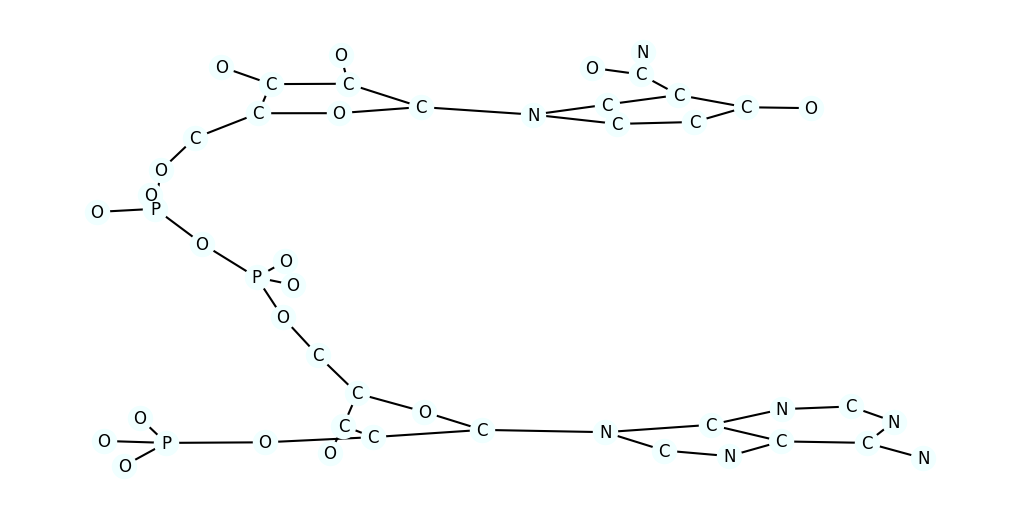

In [65]:
import pandas as pd
import torch
from torch_geometric.data import Dataset
import numpy as np 
import os
from tqdm import tqdm
import deepchem as dc
from rdkit import Chem
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

class DopingDataset(Dataset):
    def __init__(self, root, filename, atom_map, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        self.atom_map = atom_map
        super(DopingDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["SMILES"])
            if mol is None:
                print(f"Invalid SMILES string at index {index}: {row['SMILES']}")
                continue
            try:
                f = featurizer._featurize(mol)
                if len(f.edge_index) == 0 or f.edge_features is None or f.edge_features.size == 0:
                    print(f"No bonds found in molecule at index {index}: {row['SMILES']}")
                    continue
                data = f.to_pyg_graph()
                data.y = self._get_label(row["Doping"])
                data.smiles = row["SMILES"]
                data.atom_indices = [self.atom_map.index(atom.GetSymbol()) for atom in mol.GetAtoms()]
                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        try:
            if self.test:
                data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))        
            return data
        except FileNotFoundError:
            print(f"File not found for index {idx}, skipping.")
            return None

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.spring_layout(g)
    
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

def to_molecule(data, atom_map):
    g = to_networkx(data, node_attrs=['x'])
   
    for u, node_data in g.nodes(data=True):
        atom_idx = data.atom_indices[u]
        node_data['name'] = atom_map[atom_idx]
        del node_data['x']
    return g

# Define ATOM_MAP
ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']

# Instantiate and process the dataset
dataset = DopingDataset(root="data", filename="updated_only_smiles.csv", atom_map=ATOM_MAP)

# Ensure all files are generated
dataset.process()

# Collect valid data points
valid_data = [data for data in dataset if data is not None]

print(f"Number of valid data points: {len(valid_data)}")

# Draw a random molecule from valid data
data_sample = random.choice(valid_data)
print(f"SMILES formula: {data_sample.smiles}")
mol = to_molecule(data_sample, ATOM_MAP)
plt.figure(figsize=(10, 5))
draw_molecule(mol)


SMILES formula: [H]N1C=C(C2=CC=CC=C12)C1=C(C(=O)N([H])C1=O)C1=CN(CC[C@@H]2CCCN2C)C2=CC=CC=C12


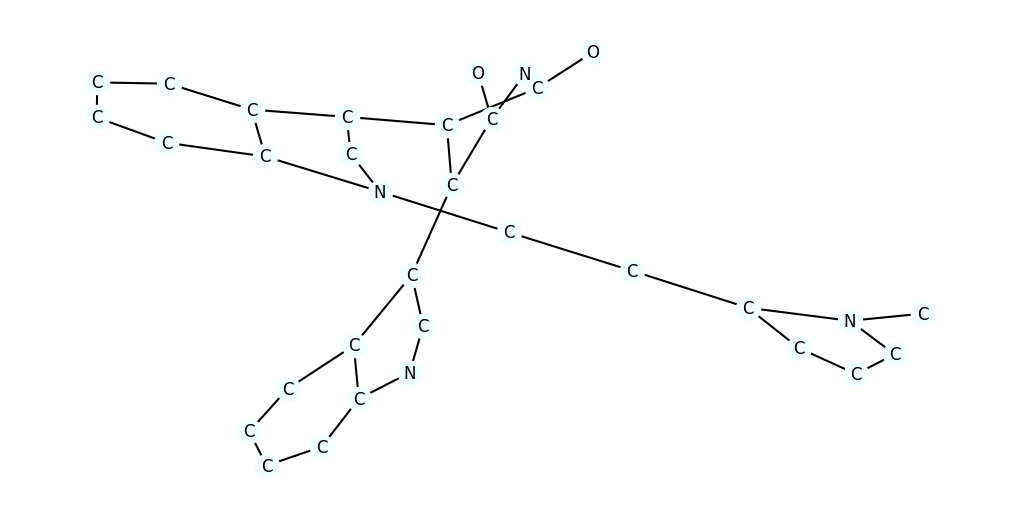

In [78]:
data_sample = random.choice(valid_data)
print(f"SMILES formula: {data_sample.smiles}")
mol = to_molecule(data_sample, ATOM_MAP)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [79]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


In [81]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [83]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool
from torch_geometric.data import DataLoader

# Define the model
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

# Custom DataLoader to skip missing files
class SafeDataLoader(DataLoader):
    def __iter__(self):
        for data in super().__iter__():
            if data is None:
                continue
            yield data

# Training and testing functions
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Set up the device, model, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use the SafeDataLoader to handle missing files
train_loader = SafeDataLoader(valid_data[:int(0.8*len(valid_data))], batch_size=32, shuffle=True)
test_loader = SafeDataLoader(valid_data[int(0.8*len(valid_data)):], batch_size=32, shuffle=False)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


File not found for index 642, skipping.
File not found for index 1032, skipping.
File not found for index 1172, skipping.
File not found for index 1182, skipping.
File not found for index 1191, skipping.
File not found for index 1192, skipping.
File not found for index 1194, skipping.
File not found for index 1195, skipping.
File not found for index 1368, skipping.
File not found for index 1384, skipping.
File not found for index 1385, skipping.
File not found for index 1691, skipping.
File not found for index 1760, skipping.
File not found for index 1916, skipping.
File not found for index 2382, skipping.
File not found for index 3717, skipping.
File not found for index 3736, skipping.
File not found for index 4008, skipping.
File not found for index 4034, skipping.
File not found for index 4847, skipping.
File not found for index 5092, skipping.
File not found for index 5098, skipping.
File not found for index 5130, skipping.
File not found for index 5135, skipping.
File not found fo

c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 001, Loss: 0.2693, Train Acc: 0.9479, Test Acc: 0.9465
Epoch: 002, Loss: 0.2065, Train Acc: 0.9478, Test Acc: 0.9465
Epoch: 003, Loss: 0.1949, Train Acc: 0.9516, Test Acc: 0.9482
Epoch: 004, Loss: 0.1861, Train Acc: 0.9528, Test Acc: 0.9482
Epoch: 005, Loss: 0.1801, Train Acc: 0.9507, Test Acc: 0.9482
Epoch: 006, Loss: 0.1700, Train Acc: 0.9479, Test Acc: 0.9465
Epoch: 007, Loss: 0.1650, Train Acc: 0.9539, Test Acc: 0.9507
Epoch: 008, Loss: 0.1577, Train Acc: 0.9532, Test Acc: 0.9473
Epoch: 009, Loss: 0.1545, Train Acc: 0.9546, Test Acc: 0.9529
Epoch: 010, Loss: 0.1479, Train Acc: 0.9547, Test Acc: 0.9546
Epoch: 011, Loss: 0.1413, Train Acc: 0.9542, Test Acc: 0.9529
Epoch: 012, Loss: 0.1416, Train Acc: 0.9526, Test Acc: 0.9486
Epoch: 013, Loss: 0.1373, Train Acc: 0.9560, Test Acc: 0.9507
Epoch: 014, Loss: 0.1331, Train Acc: 0.9576, Test Acc: 0.9533
Epoch: 015, Loss: 0.1299, Train Acc: 0.9568, Test Acc: 0.9448
Epoch: 016, Loss: 0.1262, Train Acc: 0.9547, Test Acc: 0.9503
Epoch: 0

In [84]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [39]:
def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes


File not found for index 642, skipping.
File not found for index 1032, skipping.
File not found for index 1172, skipping.
File not found for index 1182, skipping.
File not found for index 1191, skipping.
SMILES formula: CCOC(=O)N1CCC(CC1)=C1C2=C(CCC3=C1N=CC=C3)C=C(Cl)C=C2


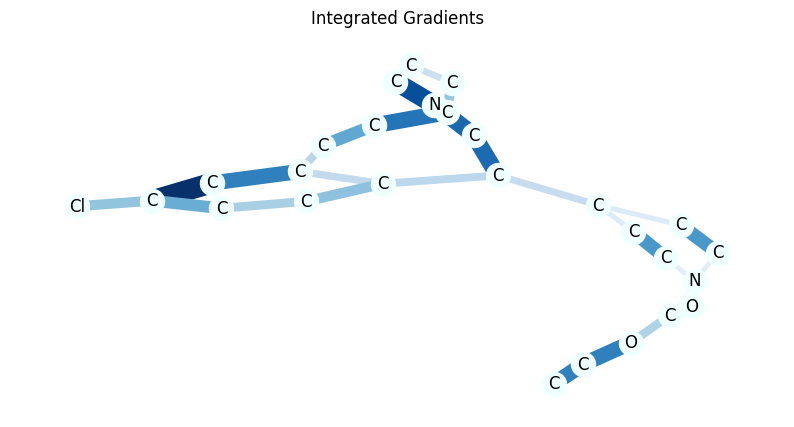

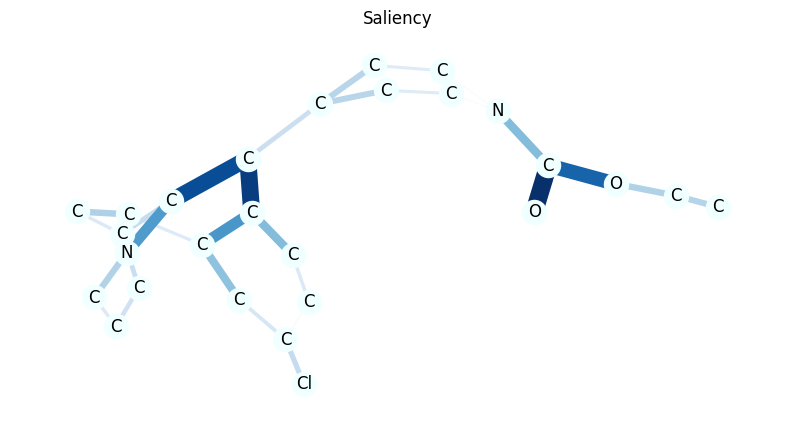

In [93]:
import random
from collections import defaultdict

# Function to aggregate edge directions
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

# Custom function to filter out missing data
def filter_existing_data(dataset):
    existing_data = []
    for i in range(len(dataset)):
        try:
            data = dataset.get(i)
            if data is not None:
                existing_data.append(data)
        except FileNotFoundError:
            print(f"File not found for index {i}, skipping.")
    return existing_data

# Filter test_dataset to only include existing data
filtered_test_dataset = filter_existing_data(test_dataset)

# Sample a molecule once from the filtered test dataset
data = random.choice([t for t in filtered_test_dataset if not t.y.item()])
mol = to_molecule(data, ATOM_MAP)
print(f"SMILES formula: {data.smiles}")

# Use the same molecule for both methods
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)


File not found for index 642, skipping.
File not found for index 1032, skipping.
File not found for index 1172, skipping.
File not found for index 1182, skipping.
File not found for index 1191, skipping.
SMILES formula: CCN1C=C(C(O)=O)C(=O)C2=CC(F)=C(N=C12)N1CCNCC1


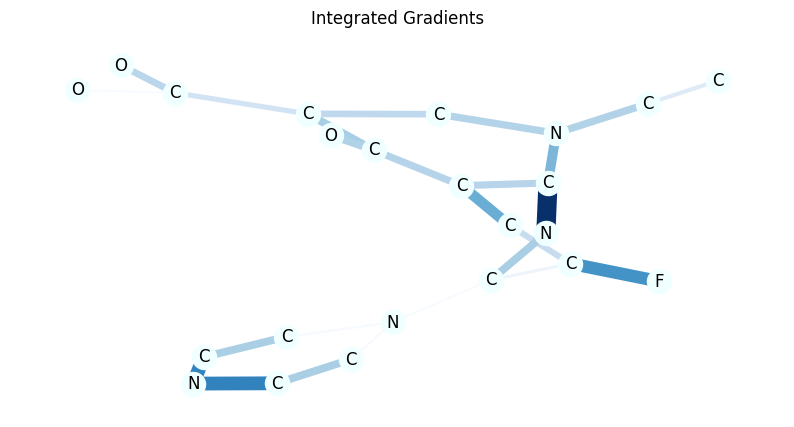

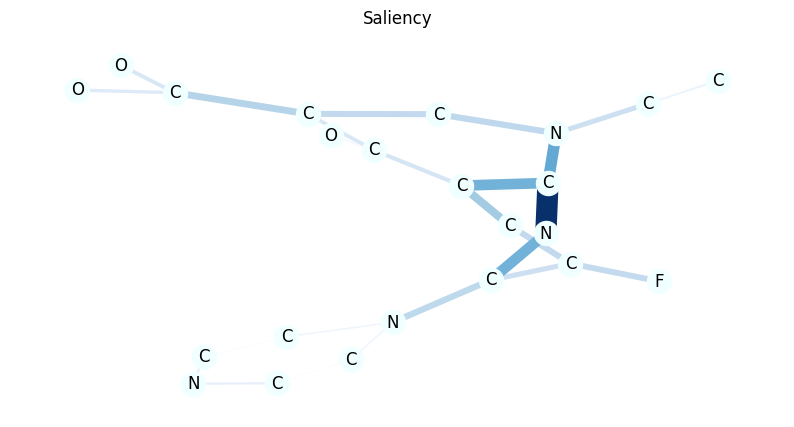

In [97]:
import random
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Function to aggregate edge directions
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

# Custom function to filter out missing data
def filter_existing_data(dataset):
    existing_data = []
    for i in range(len(dataset)):
        try:
            data = dataset.get(i)
            if data is not None:
                existing_data.append(data)
        except FileNotFoundError:
            print(f"File not found for index {i}, skipping.")
    return existing_data

# Filter test_dataset to only include existing data
filtered_test_dataset = filter_existing_data(test_dataset)

# Sample a molecule once from the filtered test dataset
data = random.choice([t for t in filtered_test_dataset if not t.y.item()])
mol = to_molecule(data, ATOM_MAP)
print(f"SMILES formula: {data.smiles}")

# Precompute the layout for consistent drawing
def compute_layout(mol):
    g = mol.copy().to_undirected()
    return nx.spring_layout(g)

layout = compute_layout(mol)

# Updated draw_molecule function to use the precomputed layout
def draw_molecule(g, edge_mask=None, draw_edge_labels=False, layout=None):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    if layout is None:
        pos = nx.spring_layout(g)
    else:
        pos = layout
    
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

# Use the same molecule and layout for both methods
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict, layout=layout)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[(0, 1), (1, 0), (1, 2), (1, 6), (2, 1), (2, 3), (3, 2), (3, 4), (3, 5), (4, 3), (5, 3), (6, 1), (6, 7), (6, 8), (7, 6), (8, 6)]
Integrated Gradients Method - Influential Edges:
Edge (4, 3) with importance 1.0000
Edge (5, 3) with importance 1.0000
Edge (2, 1) with importance 0.8987
Edge (6, 1) with importance 0.7549
Edge (2, 3) with importance 0.7151
Edge (6, 8) with importance 0.5802
Edge (3, 2) with importance 0.3901
Edge (8, 6) with importance 0.3821
Edge (0, 1) with importance 0.2805
Edge (3, 4) with importance 0.2394
Integrated Gradients Method - Influential Nodes:
Node 0
Node 1
Node 2
Node 3
Node 4
Node 5
Node 6
Node 8
[(0, 1), (1, 2), (1, 6), (2, 3), (3, 4), (3, 5), (6, 7), (6, 8)]
{0: array([-0.28511801, -0.08721709]), 1: array([-0.31996691, -0.03021196]), 2: array([-0.4090762, -0.0515857]), 3: array([-0.4949349 , -0.07050408]), 4: array([-0.53397602, -0.12323084]), 5: array([-0.55855087, -0.04495779]), 6: array([-0

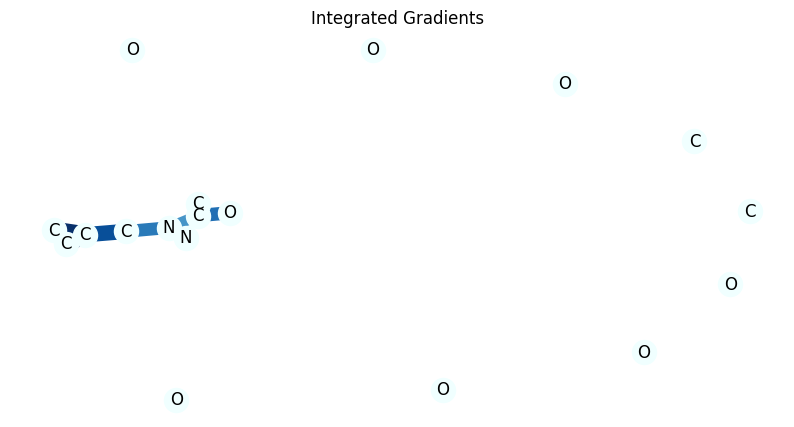

Saliency Method - Influential Edges:
Edge (1, 2) with importance 1.0000
Edge (0, 1) with importance 0.6585
Edge (1, 6) with importance 0.5562
Edge (4, 3) with importance 0.4937
Edge (5, 3) with importance 0.4937
Edge (1, 0) with importance 0.3399
Edge (3, 2) with importance 0.2837
Edge (6, 1) with importance 0.1954
Edge (8, 6) with importance 0.1740
Edge (3, 4) with importance 0.0751
Saliency Method - Influential Nodes:
Node 0
Node 1
Node 2
Node 3
Node 4
Node 5
Node 6
Node 8
[(0, 1), (1, 2), (1, 6), (2, 3), (3, 4), (3, 5), (6, 7), (6, 8)]
{0: array([-0.28511801, -0.08721709]), 1: array([-0.31996691, -0.03021196]), 2: array([-0.4090762, -0.0515857]), 3: array([-0.4949349 , -0.07050408]), 4: array([-0.53397602, -0.12323084]), 5: array([-0.55855087, -0.04495779]), 6: array([-0.25960759,  0.03744863]), 7: array([-0.26016813,  0.10328903]), 8: array([-0.19377171,  0.05346654]), 9: array([ 0.66518494, -0.73439662]), 10: array([ 0.24798286, -0.94707163]), 11: array([ 0.84426517, -0.35004445])

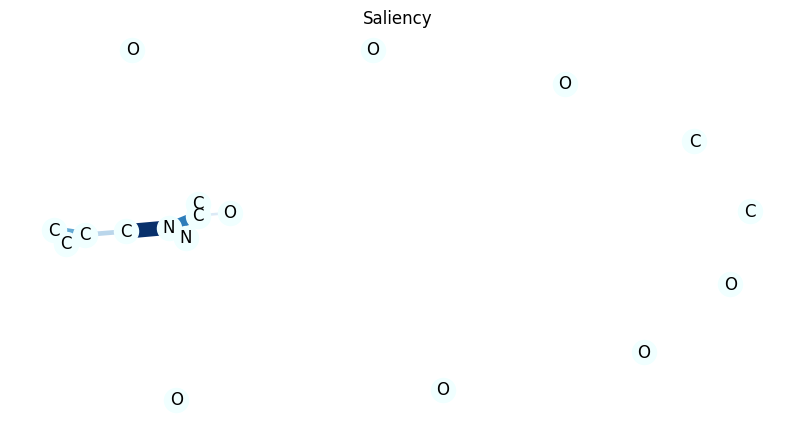

In [51]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict



# Randomly select a data sample
data = random.choice([t for t in test_dataset if not t.y.item()])

# Convert the data to a molecule object
mol = to_molecule(data)

# Generate explanations and plot
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)

    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        print(f"Edge ({u}, {v}) with importance {val:.4f}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        print(f"Node {node}")

    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

Chosen molecule SMILES: [H][C@@]12CC[C@@](O)(C#C)[C@@]1(C)CC[C@]1([H])C3=C(CC[C@@]21[H])C=C(OC)C=C3
Integrated Gradients Method - Influential Edges:
Edge (7, 9) with importance 1.0000
Edge (8, 7) with importance 0.9994
Edge (0, 7) with importance 0.8610
Edge (10, 9) with importance 0.8044
Edge (3, 7) with importance 0.7465
Edge (7, 8) with importance 0.5953
Edge (9, 7) with importance 0.4903
Edge (7, 3) with importance 0.3906
Edge (0, 16) with importance 0.3512
Edge (7, 0) with importance 0.3365
Integrated Gradients Method - Influential Nodes:
Node 0
Node 3
Node 7
Node 8
Node 9
Node 10
Node 16


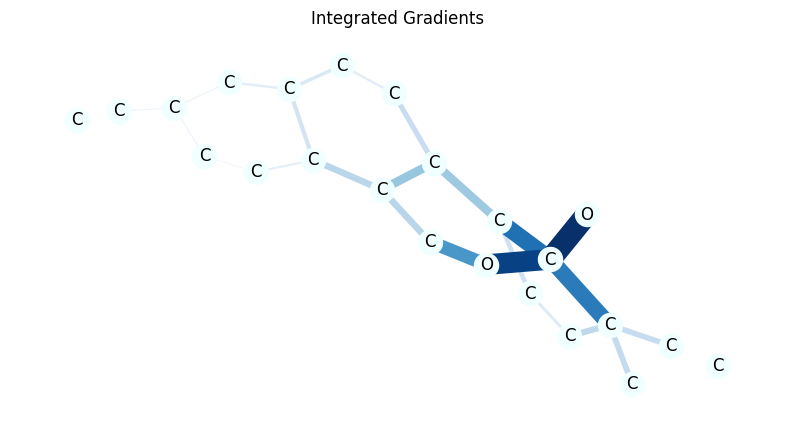

Saliency Method - Influential Edges:
Edge (3, 7) with importance 1.0000
Edge (0, 7) with importance 0.9282
Edge (7, 3) with importance 0.6238
Edge (7, 9) with importance 0.5356
Edge (2, 3) with importance 0.4411
Edge (11, 12) with importance 0.4322
Edge (13, 12) with importance 0.3873
Edge (16, 11) with importance 0.3523
Edge (5, 3) with importance 0.3468
Edge (12, 11) with importance 0.3367
Saliency Method - Influential Nodes:
Node 0
Node 2
Node 3
Node 5
Node 7
Node 9
Node 11
Node 12
Node 13
Node 16


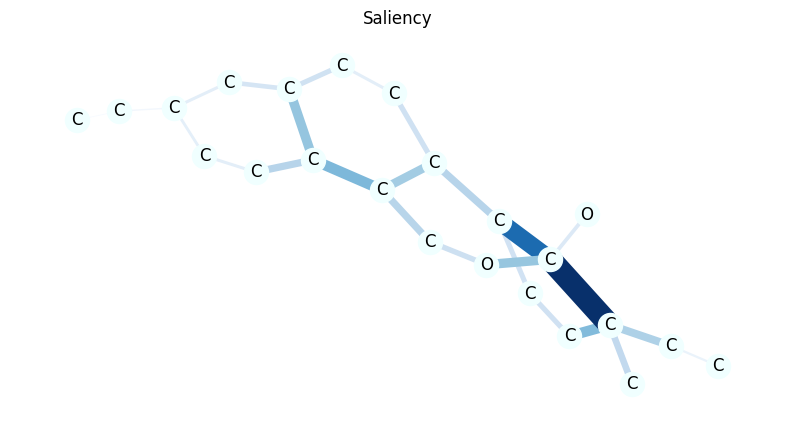

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients
from collections import defaultdict
import random
from torch_geometric.utils import to_networkx

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    # Identify isolated nodes and remove them from the graph
    isolated_nodes = list(nx.isolates(g))
    g.remove_nodes_from(isolated_nodes)
    
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    
    g = to_networkx(data, node_attrs=['x'])
    
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    
    return g

# Example usage with a random molecule from the dataset
data = random.choice([t for t in test_dataset if not t.y.item()])
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        print(f"Edge ({u}, {v}) with importance {val:.4f}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        print(f"Node {node}")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)


Chosen molecule SMILES: C[C@H](CCCC(C)(C)O)[C@@]1([H])CC[C@@]2([H])\C(CCC[C@]12C)=C\C=C1\C[C@@H](O)CCC1=C
Integrated Gradients Method - Influential Edges:
Edge (6, 5) with importance 1.0000 connecting C-C
Edge (7, 5) with importance 1.0000 connecting C-C
Edge (8, 5) with importance 1.0000 connecting C-C
Edge (3, 4) with importance 0.9186 connecting C-C
Edge (9, 17) with importance 0.8073 connecting C-O
Edge (12, 17) with importance 0.8055 connecting C-O
Edge (5, 4) with importance 0.6319 connecting C-C
Edge (18, 17) with importance 0.6114 connecting C-O
Edge (15, 16) with importance 0.4497 connecting C-O
Edge (17, 18) with importance 0.3509 connecting O-C
Integrated Gradients Method - Influential Nodes:
Node 3 (C)
Node 4 (C)
Node 5 (C)
Node 6 (C)
Node 7 (C)
Node 8 (C)
Node 9 (C)
Node 12 (C)
Node 15 (C)
Node 16 (O)
Node 17 (O)
Node 18 (C)


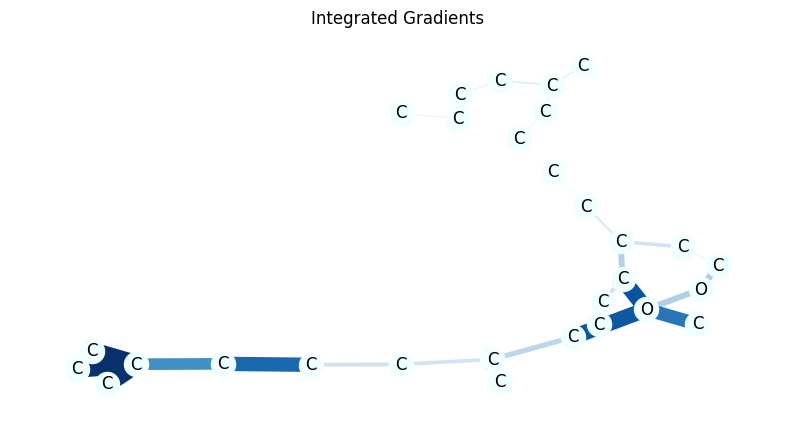

Saliency Method - Influential Edges:
Edge (12, 17) with importance 1.0000 connecting C-O
Edge (9, 17) with importance 0.9855 connecting C-O
Edge (17, 12) with importance 0.8582 connecting O-C
Edge (17, 9) with importance 0.7993 connecting O-C
Edge (13, 12) with importance 0.6761 connecting C-C
Edge (12, 13) with importance 0.6520 connecting C-C
Edge (11, 12) with importance 0.5673 connecting C-C
Edge (1, 9) with importance 0.5526 connecting C-C
Edge (18, 17) with importance 0.5271 connecting C-O
Edge (16, 17) with importance 0.4964 connecting O-O
Saliency Method - Influential Nodes:
Node 1 (C)
Node 9 (C)
Node 11 (C)
Node 12 (C)
Node 13 (C)
Node 16 (O)
Node 17 (O)
Node 18 (C)


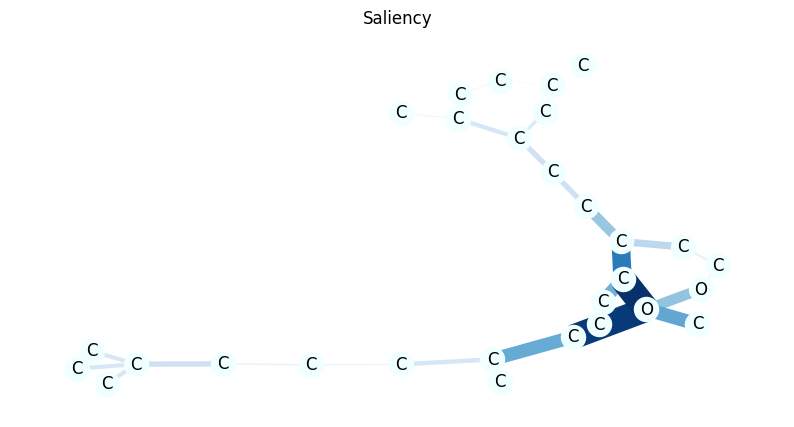

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients
from collections import defaultdict
import random
from torch_geometric.utils import to_networkx

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    # Identify isolated nodes and remove them from the graph
    isolated_nodes = list(nx.isolates(g))
    g.remove_nodes_from(isolated_nodes)
    
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    
    g = to_networkx(data, node_attrs=['x'])
    
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    
    return g

# Example usage with a random molecule from the dataset
data = random.choice([t for t in test_dataset if not t.y.item()])
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)


Chosen molecule SMILES: CC1CC2=CC=CC=C2N1NC(=O)C1=CC(=C(Cl)C=C1)S(N)(=O)=O
Integrated Gradients Method - Influential Edges:
Edge (22, 20) with importance 1.0000 connecting C-N
Edge (23, 20) with importance 1.0000 connecting C-N
Edge (15, 20) with importance 0.9068 connecting C-N
Edge (20, 15) with importance 0.7198 connecting N-C
Edge (13, 11) with importance 0.7169 connecting C-C
Edge (12, 11) with importance 0.6940 connecting C-C
Edge (9, 10) with importance 0.6198 connecting C-C
Edge (16, 18) with importance 0.6034 connecting C-N
Edge (19, 18) with importance 0.5516 connecting N-N
Edge (15, 14) with importance 0.5343 connecting C-C
Integrated Gradients Method - Influential Nodes:
Node 9 (C)
Node 10 (C)
Node 11 (C)
Node 12 (C)
Node 13 (C)
Node 14 (C)
Node 15 (C)
Node 16 (C)
Node 18 (N)
Node 19 (N)
Node 20 (N)
Node 22 (C)
Node 23 (C)


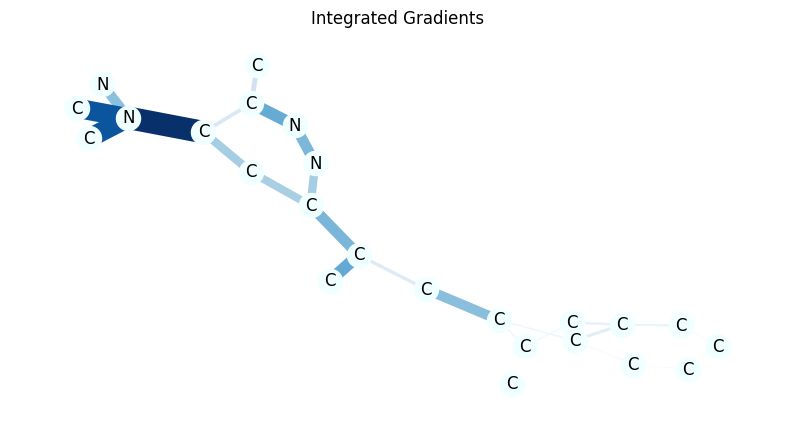

Saliency Method - Influential Edges:
Edge (20, 15) with importance 1.0000 connecting N-C
Edge (8, 9) with importance 0.8021 connecting C-C
Edge (9, 8) with importance 0.7236 connecting C-C
Edge (9, 1) with importance 0.7192 connecting C-C
Edge (1, 9) with importance 0.6748 connecting C-C
Edge (3, 8) with importance 0.6646 connecting C-C
Edge (8, 3) with importance 0.6068 connecting C-C
Edge (10, 9) with importance 0.5336 connecting C-C
Edge (7, 8) with importance 0.4807 connecting C-C
Edge (3, 2) with importance 0.4586 connecting C-C
Saliency Method - Influential Nodes:
Node 1 (C)
Node 2 (C)
Node 3 (C)
Node 7 (C)
Node 8 (C)
Node 9 (C)
Node 10 (C)
Node 15 (C)
Node 20 (N)


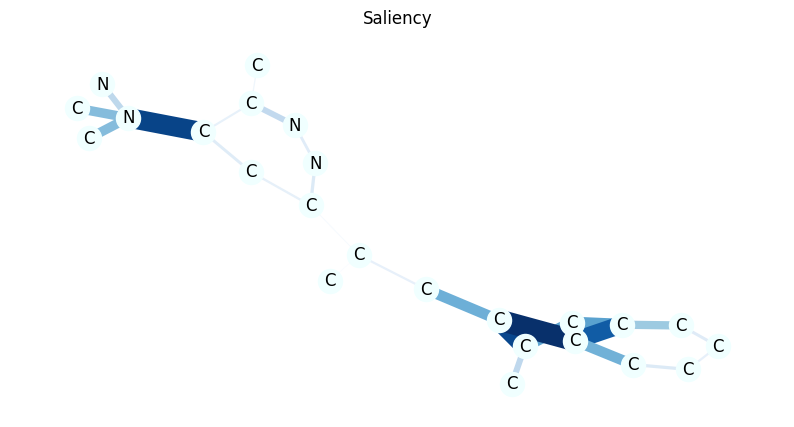

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients
from collections import defaultdict
import random
from torch_geometric.utils import to_networkx

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    # Identify isolated nodes and remove them from the graph
    isolated_nodes = list(nx.isolates(g))
    g.remove_nodes_from(isolated_nodes)
    
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    
    g = to_networkx(data, node_attrs=['x'])
    
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    
    return g

# Filter the test dataset to only include samples with target label 1 (doping drugs)
doping_samples = [t for t in test_dataset if t.y.item() == 1]

# Check if there are any doping samples available
if doping_samples:
    data = random.choice(doping_samples)
    print(f"Chosen molecule SMILES: {data.smiles}")

    mol = to_molecule(data)

    for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
        edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
        edge_mask_dict = aggregate_edge_directions(edge_mask, data)
        
        # Print influential edges and nodes
        print(f"{title} Method - Influential Edges:")
        for u, v, val in influential_edges:
            atom_u = mol.nodes[u]['name']
            atom_v = mol.nodes[v]['name']
            print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

        print(f"{title} Method - Influential Nodes:")
        for node in influential_nodes:
            atom = mol.nodes[node]['name']
            print(f"Node {node} ({atom})")
        
        plt.figure(figsize=(10, 5))
        plt.title(title)
        draw_molecule(mol, edge_mask_dict)
else:
    print("No doping samples found in the test dataset.")


Chosen molecule SMILES: CN(C)CCOC(C1=CC=C(Cl)C=C1)C1=CC=CC=N1
Integrated Gradients Method - Influential Edges:
Edge (9, 10) with importance 1.0000 connecting C-O
Edge (12, 10) with importance 1.0000 connecting C-O
Edge (1, 2) with importance 0.5324 connecting C-N
Edge (11, 10) with importance 0.3678 connecting O-O
Edge (1, 3) with importance 0.3642 connecting C-N
Edge (4, 3) with importance 0.3548 connecting C-N
Edge (6, 7) with importance 0.2638 connecting C-C
Edge (7, 8) with importance 0.2613 connecting C-C
Edge (7, 13) with importance 0.2613 connecting C-C
Edge (14, 6) with importance 0.1902 connecting C-C
Integrated Gradients Method - Influential Nodes:
Node 1 (C)
Node 2 (N)
Node 3 (N)
Node 4 (C)
Node 6 (C)
Node 7 (C)
Node 8 (C)
Node 9 (C)
Node 10 (O)
Node 11 (O)
Node 12 (C)
Node 13 (C)
Node 14 (C)


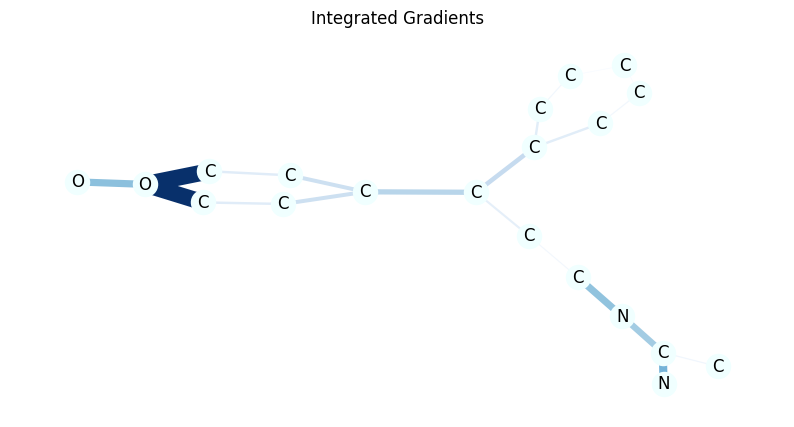

Saliency Method - Influential Edges:
Edge (3, 1) with importance 1.0000 connecting N-C
Edge (0, 1) with importance 0.9849 connecting C-C
Edge (2, 1) with importance 0.8539 connecting N-C
Edge (10, 9) with importance 0.6988 connecting O-C
Edge (10, 12) with importance 0.6988 connecting O-C
Edge (1, 0) with importance 0.6228 connecting C-C
Edge (1, 3) with importance 0.5101 connecting C-N
Edge (4, 3) with importance 0.4770 connecting C-N
Edge (11, 10) with importance 0.4487 connecting O-O
Edge (10, 11) with importance 0.4231 connecting O-O
Saliency Method - Influential Nodes:
Node 0 (C)
Node 1 (C)
Node 2 (N)
Node 3 (N)
Node 4 (C)
Node 9 (C)
Node 10 (O)
Node 11 (O)
Node 12 (C)


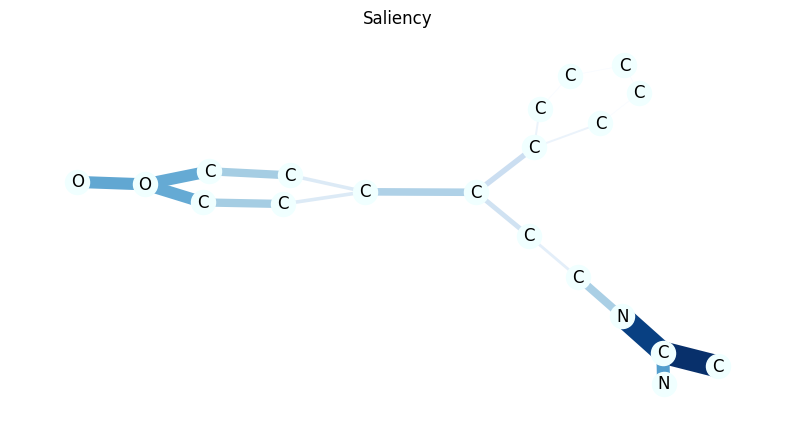

Total: 1192, Correct: 1056, Accuracy: 0.8859
TP: 26, TN: 1030, FP: 1, FN: 135
TP Rate: 0.1615, TN Rate: 0.9990, FP Rate: 0.0010, FN Rate: 0.8385


In [58]:
def test(loader, target_class=1):
    model.eval()
    correct = 0
    total = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        
        # Count total correct predictions
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
        
        # Calculate TP, TN, FP, FN
        for i in range(data.y.size(0)):
            if pred[i] == target_class and data.y[i] == target_class:
                tp += 1
            elif pred[i] == target_class and data.y[i] != target_class:
                fp += 1
            elif pred[i] != target_class and data.y[i] == target_class:
                fn += 1
            elif pred[i] != target_class and data.y[i] != target_class:
                tn += 1

    accuracy = correct / total
    tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

    print(f'Total: {total}, Correct: {correct}, Accuracy: {accuracy:.4f}')
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f'TP Rate: {tp_rate:.4f}, TN Rate: {tn_rate:.4f}, FP Rate: {fp_rate:.4f}, FN Rate: {fn_rate:.4f}')

    return accuracy, tp, tn, fp, fn

# Example usage with a random molecule from the dataset
data = random.choice([t for t in test_dataset if not t.y.item()])
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

# Test the model on the test dataset and print TP, TN, FP, FN rates
test_loader = DataLoader(test_dataset, batch_size=128)
accuracy, tp, tn, fp, fn = test(test_loader, target_class=1)

Chosen molecule SMILES: [H][C@@]12C[C@H](C)[C@](O)(C(=O)CCl)[C@@]1(C)C[C@H](O)[C@@]1(F)[C@@]2([H])C[C@H](F)C2=CC(=O)C=C[C@]12C
Integrated Gradients Method - Influential Edges:
Edge (26, 27) with importance 1.0000 connecting C-C
Edge (21, 27) with importance 0.9374 connecting C-C
Edge (4, 10) with importance 0.8322 connecting C-O
Edge (21, 19) with importance 0.8271 connecting C-Cl
Edge (18, 19) with importance 0.7918 connecting Cl-Cl
Edge (27, 28) with importance 0.7330 connecting C-O
Edge (0, 10) with importance 0.7249 connecting C-O
Edge (20, 19) with importance 0.7216 connecting C-Cl
Edge (0, 17) with importance 0.6990 connecting C-C
Edge (13, 14) with importance 0.6726 connecting C-O
Integrated Gradients Method - Influential Nodes:
Node 0 (C)
Node 4 (C)
Node 10 (O)
Node 13 (C)
Node 14 (O)
Node 17 (C)
Node 18 (Cl)
Node 19 (Cl)
Node 20 (C)
Node 21 (C)
Node 26 (C)
Node 27 (C)
Node 28 (O)


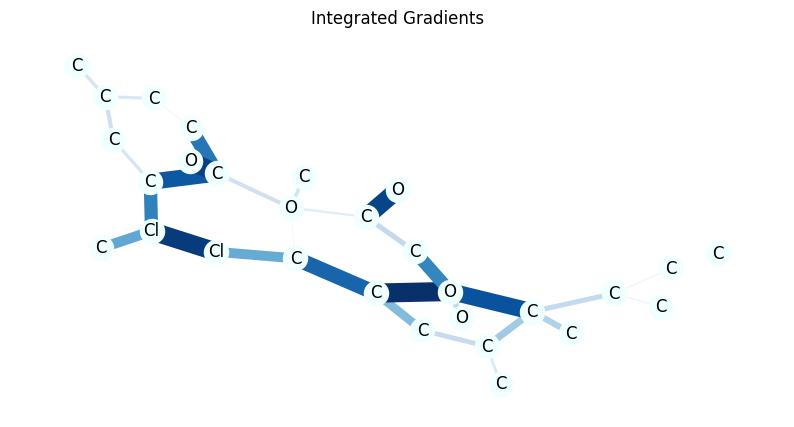

Saliency Method - Influential Edges:
Edge (19, 20) with importance 1.0000 connecting Cl-C
Edge (19, 18) with importance 0.7849 connecting Cl-Cl
Edge (18, 19) with importance 0.6991 connecting Cl-Cl
Edge (20, 19) with importance 0.5520 connecting C-Cl
Edge (4, 2) with importance 0.4899 connecting C-C
Edge (4, 10) with importance 0.4686 connecting C-O
Edge (17, 18) with importance 0.4109 connecting C-Cl
Edge (17, 15) with importance 0.3937 connecting C-O
Edge (21, 27) with importance 0.3922 connecting C-C
Edge (19, 21) with importance 0.3875 connecting Cl-C
Saliency Method - Influential Nodes:
Node 2 (C)
Node 4 (C)
Node 10 (O)
Node 15 (O)
Node 17 (C)
Node 18 (Cl)
Node 19 (Cl)
Node 20 (C)
Node 21 (C)
Node 27 (C)


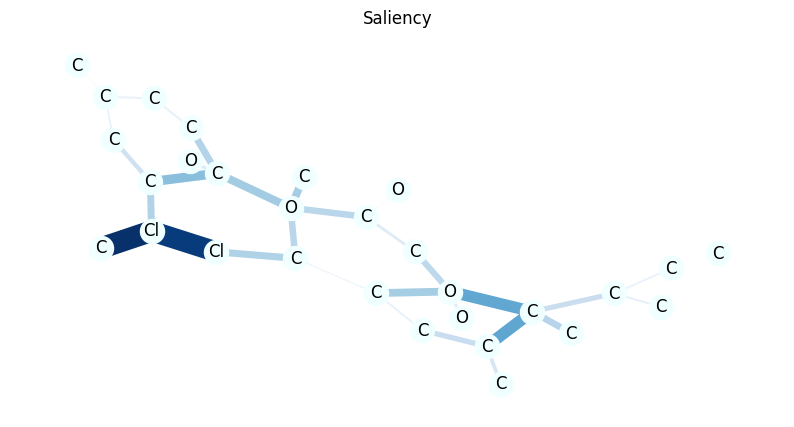

Total: 322, Correct: 187, Accuracy: 0.5807
TP: 26, TN: 161, FP: 0, FN: 135
TP Rate: 0.1615, TN Rate: 1.0000, FP Rate: 0.0000, FN Rate: 0.8385


In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients
from collections import defaultdict
import random
from torch_geometric.utils import to_networkx
from torch_geometric.data import DataLoader

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    # Identify isolated nodes and remove them from the graph
    isolated_nodes = list(nx.isolates(g))
    g.remove_nodes_from(isolated_nodes)
    
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    
    g = to_networkx(data, node_attrs=['x'])
    
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    
    return g

def test(loader, target_class=1):
    model.eval()
    correct = 0
    total = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        
        # Count total correct predictions
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
        
        # Calculate TP, TN, FP, FN
        for i in range(data.y.size(0)):
            if pred[i] == target_class and data.y[i] == target_class:
                tp += 1
            elif pred[i] == target_class and data.y[i] != target_class:
                fp += 1
            elif pred[i] != target_class and data.y[i] == target_class:
                fn += 1
            elif pred[i] != target_class and data.y[i] != target_class:
                tn += 1

    accuracy = correct / total
    tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

    print(f'Total: {total}, Correct: {correct}, Accuracy: {accuracy:.4f}')
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f'TP Rate: {tp_rate:.4f}, TN Rate: {tn_rate:.4f}, FP Rate: {fp_rate:.4f}, FN Rate: {fn_rate:.4f}')

    return accuracy, tp, tn, fp, fn

# Subsampling function to create balanced datasets
def create_balanced_dataset(dataset):
    doping_samples = [data for data in dataset if data.y.item() == 1]
    non_doping_samples = [data for data in dataset if data.y.item() == 0]

    # Subsample the majority class to match the number of minority class samples
    if len(doping_samples) < len(non_doping_samples):
        non_doping_samples = random.sample(non_doping_samples, len(doping_samples))
    else:
        doping_samples = random.sample(doping_samples, len(non_doping_samples))
    
    balanced_dataset = doping_samples + non_doping_samples
    random.shuffle(balanced_dataset)
    return balanced_dataset

# Create balanced training and test datasets
train_dataset_balanced = create_balanced_dataset(train_dataset)
test_dataset_balanced = create_balanced_dataset(test_dataset)

# Create DataLoaders
train_loader = DataLoader(train_dataset_balanced, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_balanced, batch_size=128, shuffle=False)

# Example usage with a random molecule from the balanced test dataset
data = random.choice([t for t in test_dataset_balanced if t.y.item() == 1])
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

# Test the model on the balanced test dataset and print TP, TN, FP, FN rates
accuracy, tp, tn, fp, fn = test(test_loader, target_class=1)
